# 마케팅 ROI 심층 분석 리포트

**기간**: 2024-10-01 ~ 2024-12-29 (90일)  
**채널**: Google Ads, Facebook Ads, Naver Ads  
**목표**: 채널별 ROAS 분석 → 예산 최적화 제안 → 비즈니스 인사이트 도출

### Executive Summary

> **핵심 결론**: 동일 예산(₩2.3억)을 ROAS 가중 기반으로 재배분하면 **+4.3% 매출 증가**(약 ₩2,600만)가 가능합니다.

| 발견 | 수치 | 비즈니스 임팩트 |
|------|------|-----------------|
| Naver Ads가 최고 효율 채널 | ROAS 3.28 (vs Google 2.77, Facebook 2.05) | 네이버 예산 30.9% → 40.4% 증액 권장 |
| 전 채널 체감수익 확인 | 로그 회귀 R² > 선형 R² | 단일 채널 과잉 투자보다 다채널 분산이 유리 |
| Brand 캠페인이 전 채널 최고 ROAS | Retargeting > Generic/Interest 순 | Brand 키워드 방어 예산 우선 확보 |

**이 분석은 다음 질문에 답합니다:**
1. 어떤 채널에 예산을 더 투자해야 하는가?
2. 광고비를 늘리면 매출도 비례해서 늘어나는가?
3. 통계적으로 유의미한 패턴은 무엇이고, 어떻게 활용할 수 있는가?

---

## 비즈니스 컨텍스트

### 문제 정의
중소 이커머스 기업이 Google Ads, Facebook Ads, 네이버 검색광고 3개 채널에 월 평균 ₩7,500만(약 $57,000)을 집행하고 있습니다. 그러나 **채널별 실제 수익 기여도**와 **최적 예산 배분**에 대한 데이터 기반 의사결정이 부재한 상황입니다.

### 분석 목표
1. **채널 효율성 비교**: ROAS, CTR, CVR 등 핵심 지표로 채널 간 성과 격차를 정량화
2. **패턴 발견**: 요일별, 캠페인 유형별 성과 패턴을 식별하여 운영 최적화 기회 도출
3. **예산 최적화**: 체감수익(Diminishing Returns) 분석을 통한 데이터 기반 예산 재배분안 제시
4. **이상치 모니터링**: 비정상적 성과 변동을 자동 탐지하여 운영 리스크 관리 강화

### 접근 방법
EDA → 통계 검정 → 회귀 모델링 → 최적화 시뮬레이션 순으로 진행하며, 각 단계에서 도출된 인사이트가 다음 단계의 분석 방향을 결정하는 **가설 주도형 분석(Hypothesis-Driven Analysis)** 프레임워크를 적용합니다.

## 1. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
import os

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (OS별 자동 감지)
import platform
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif system == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (12, 6)

# 채널별 고정 색상
CHANNEL_COLORS = {
    'Google Ads': '#4285F4',
    'Facebook Ads': '#1877F2',
    'Naver Ads': '#03C75A'
}

# 차트 저장 디렉토리
CHARTS_DIR = 'charts'
os.makedirs(CHARTS_DIR, exist_ok=True)

def save_chart(fig, filename):
    """차트를 PNG로 저장"""
    path = os.path.join(CHARTS_DIR, filename)
    fig.savefig(path, bbox_inches='tight', facecolor='white')
    print(f'저장: {path}')

print('환경 설정 완료')
print(f'OS: {system}')
print(f'pandas: {pd.__version__}')

환경 설정 완료
OS: Windows
pandas: 2.3.3


In [2]:
# 공통 유틸리티 함수 정의

def format_krw(value):
    """숫자를 한국 원화 형식으로 포맷"""
    return f'₩{value:,.0f}'

def format_pct(value):
    """소수를 퍼센트 문자열로 변환"""
    return f'{value*100:.1f}%'

def get_channel_color(channel):
    """채널명으로 브랜드 색상 반환"""
    return CHANNEL_COLORS.get(channel, '#888888')

def fit_log_regression(X, y):
    """로그 회귀 모델 학습 후 (model, R²) 반환"""
    X_log = np.log1p(X)
    model = LinearRegression().fit(X_log, y)
    r2 = r2_score(y, model.predict(X_log))
    return model, r2

def fit_three_models(X, y):
    """선형/로그/다항식 3가지 회귀 모델을 학습하고 결과 반환"""
    x_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    results = {}
    # 선형
    lr = LinearRegression().fit(X, y)
    results['선형'] = {'pred': lr.predict(x_plot), 'r2': r2_score(y, lr.predict(X)),
                      'style': '--', 'color': 'orange'}
    # 로그
    lr_log = LinearRegression().fit(np.log1p(X), y)
    results['로그'] = {'pred': lr_log.predict(np.log1p(x_plot)), 'r2': r2_score(y, lr_log.predict(np.log1p(X))),
                      'style': '-', 'color': 'red'}
    # 다항식
    poly = PolynomialFeatures(degree=2)
    lr_poly = LinearRegression().fit(poly.fit_transform(X), y)
    results['다항식'] = {'pred': lr_poly.predict(poly.transform(x_plot)), 'r2': r2_score(y, lr_poly.predict(poly.transform(X))),
                       'style': '-.', 'color': 'purple'}
    return results, x_plot

def detect_roas_outliers(channel_daily, threshold=2):
    """Z-score 기반 ROAS 이상치 탐지"""
    mean_r = channel_daily['roas'].mean()
    std_r = channel_daily['roas'].std()
    channel_daily = channel_daily.copy()
    channel_daily['z_score'] = (channel_daily['roas'] - mean_r) / std_r
    outliers = channel_daily[channel_daily['z_score'].abs() > threshold]
    return channel_daily, outliers

print(f'유틸리티 함수 로드 완료 (6개)')

유틸리티 함수 로드 완료 (6개)


## 2. 데이터 로딩 및 품질 점검

**데이터 출처**: `generate_data.py`로 생성한 실무급 시뮬레이션 데이터  
- 12가지 실무 마케팅 패턴 반영 (채널 효율성, 요일 효과, 광고 피로도, 예산 제약, A/B 테스트, 계절성 등)
- 비즈니스 이벤트 포함: 블랙프라이데이(11/28~12/01), 11.11 세일, Facebook 추적 장애(12/18~19)
- ±15~25% 노이즈로 실제 마케팅 데이터의 복잡성 재현

| 컬럼 | 설명 | 비즈니스 의미 |
|------|------|---------------|
| `date` | 일자 (90일) | 시계열 분석의 기본 축 |
| `channel` | 광고 채널 (3개) | 예산 배분 의사결정 단위 |
| `campaign` | 캠페인명 (채널당 3개) | 전략별 성과 비교 단위 |
| `cost` | 광고비 ($) | 투자 (Input) |
| `impressions` ~ `conversions` | 퍼널 단계별 지표 | 이탈 구간 식별 |
| `revenue` | 매출 ($) | 성과 (Output) |

In [3]:
# 데이터 로딩
df = pd.read_csv('data/marketing_raw_data.csv', parse_dates=['date'])

print(f'데이터 shape: {df.shape}')
print(f'기간: {df["date"].min().strftime("%Y-%m-%d")} ~ {df["date"].max().strftime("%Y-%m-%d")}')
print(f'채널: {df["channel"].unique().tolist()}')
print(f'캠페인 수: {df["campaign"].nunique()}')
print()
df.head(10)

데이터 shape: (810, 8)
기간: 2024-10-01 ~ 2024-12-29
채널: ['Google Ads', 'Facebook Ads', 'Naver Ads']
캠페인 수: 9



,date,channel,campaign,cost,impressions,clicks,conversions,revenue
0,2024-10-01,Google Ads,Google_Brand,189.64,14209,947,50,668.01
1,2024-10-01,Google Ads,Google_Generic,414.73,30205,979,17,809.34
2,2024-10-01,Google Ads,Google_Retargeting,120.57,8425,567,15,329.24
3,2024-10-01,Facebook Ads,FB_Interest,153.27,17059,659,16,216.93
4,2024-10-01,Facebook Ads,FB_Lookalike,200.50,16581,528,18,418.51
5,2024-10-01,Facebook Ads,FB_Retargeting,94.27,8493,393,18,192.52
6,2024-10-01,Naver Ads,Naver_Brand,150.02,9701,701,49,492.73
7,2024-10-01,Naver Ads,Naver_Shopping,229.60,21911,1015,32,472.87
8,2024-10-01,Naver Ads,Naver_Retargeting,102.22,11441,808,47,391.38
9,2024-10-02,Google Ads,Google_Brand,199.15,21024,1603,85,766.44


In [4]:
# 데이터 타입 확인
print('=== 데이터 타입 ===')
print(df.dtypes)
print()

# 결측치 확인
print('=== 결측치 ===')
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else '결측치 없음')
print()

# 기술 통계
print('=== 기술 통계 ===')
df.describe().round(2)

=== 데이터 타입 ===
date           datetime64[ns]
channel                object
campaign               object
cost                  float64
impressions             int64
clicks                  int64
conversions             int64
revenue               float64
dtype: object

=== 결측치 ===
결측치 없음

=== 기술 통계 ===


,date,cost,impressions,clicks,conversions,revenue
count,810,810.00,810.00,810.00,810.00,810.00
mean,2024-11-14 12:00:00,202.68,18265.43,854.22,38.87,539.66
min,2024-10-01 00:00:00,43.30,2547.00,159.00,2.00,85.54
25%,2024-10-23 00:00:00,119.50,10293.75,546.25,20.00,321.67
50%,2024-11-14 12:00:00,171.22,15170.00,745.50,31.00,462.16
75%,2024-12-07 00:00:00,259.62,23775.00,1039.75,47.00,671.36
max,2024-12-29 00:00:00,627.72,70491.00,3529.00,352.00,2340.63
std,NaN,110.90,11226.18,445.01,30.42,316.34


In [5]:
# 파생 변수 생성
df['roas'] = df['revenue'] / df['cost']
df['ctr'] = df['clicks'] / df['impressions']
df['cvr'] = np.where(df['clicks'] > 0, df['conversions'] / df['clicks'], 0)
df['cpc'] = df['cost'] / df['clicks']
df['weekday'] = df['date'].dt.dayofweek  # 0=월, 6=일
df['weekday_name'] = df['date'].dt.day_name()
df['is_weekend'] = df['weekday'].isin([5, 6])
df['week'] = df['date'].dt.isocalendar().week.astype(int)

print(f'파생 변수 추가 완료. 총 컬럼: {len(df.columns)}')
print(f'추가된 컬럼: roas, ctr, cvr, cpc, weekday, weekday_name, is_weekend, week')

파생 변수 추가 완료. 총 컬럼: 16
추가된 컬럼: roas, ctr, cvr, cpc, weekday, weekday_name, is_weekend, week


## 3. 탐색적 데이터 분석 (EDA)

본격적인 모델링에 앞서, 데이터에 숨겨진 패턴을 시각적으로 탐색합니다.

**탐색 질문**:
- 채널별 광고비 대비 매출 효율(ROAS)에 유의미한 차이가 있는가?
- 시간에 따른 ROAS 추이에 트렌드나 이상 패턴이 존재하는가?
- 동일 채널 내에서도 캠페인 유형(Brand/Generic/Retargeting)별 효율 격차가 있는가?

이 단계에서 발견된 패턴은 이후 통계 검정과 회귀 분석의 **가설**로 이어집니다.

저장: charts\01_channel_cost_revenue.png


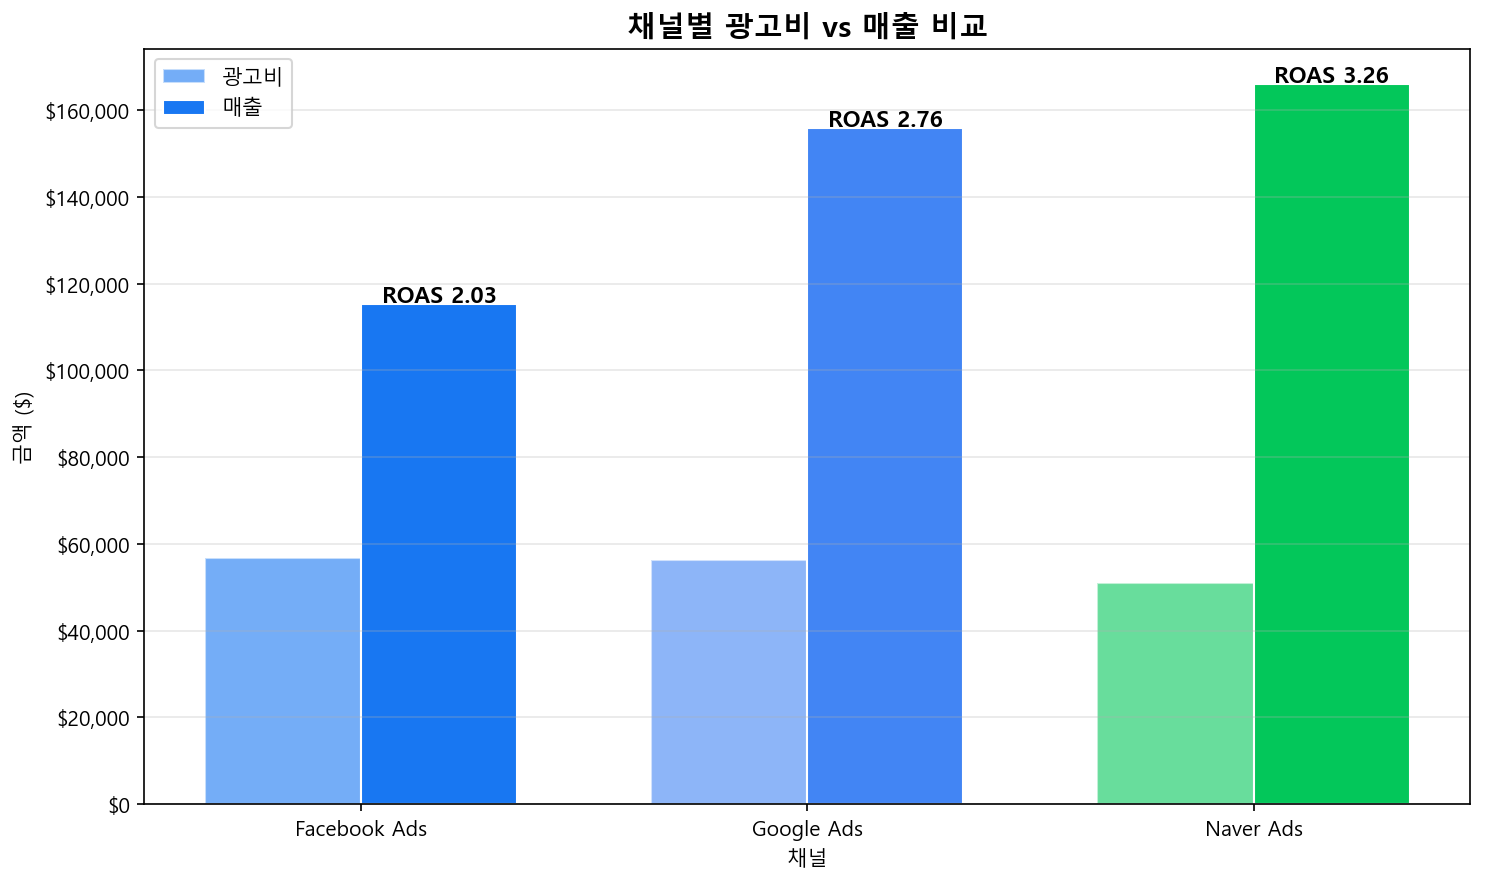

In [6]:
# 차트 1: 채널별 광고비-매출 비교 (Grouped Bar)
channel_summary = df.groupby('channel').agg(
    total_cost=('cost', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_conversions=('conversions', 'sum')
).reset_index()
channel_summary['roas'] = channel_summary['total_revenue'] / channel_summary['total_cost']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(channel_summary))
width = 0.35

bars1 = ax.bar(x - width/2, channel_summary['total_cost'], width,
               label='광고비', color=[get_channel_color(c) for c in channel_summary['channel']],
               alpha=0.6, edgecolor='white')
bars2 = ax.bar(x + width/2, channel_summary['total_revenue'], width,
               label='매출', color=[get_channel_color(c) for c in channel_summary['channel']],
               alpha=1.0, edgecolor='white')

# ROAS 텍스트 표시
for i, row in channel_summary.iterrows():
    ax.text(i + width/2, row['total_revenue'] + 500,
            f'ROAS {row["roas"]:.2f}', ha='center', fontweight='bold', fontsize=11)

ax.set_xlabel('채널')
ax.set_ylabel('금액 ($)')
ax.set_title('채널별 광고비 vs 매출 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(channel_summary['channel'])
ax.legend()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '01_channel_cost_revenue.png')
plt.show()

저장: charts\02_daily_roas_trend.png


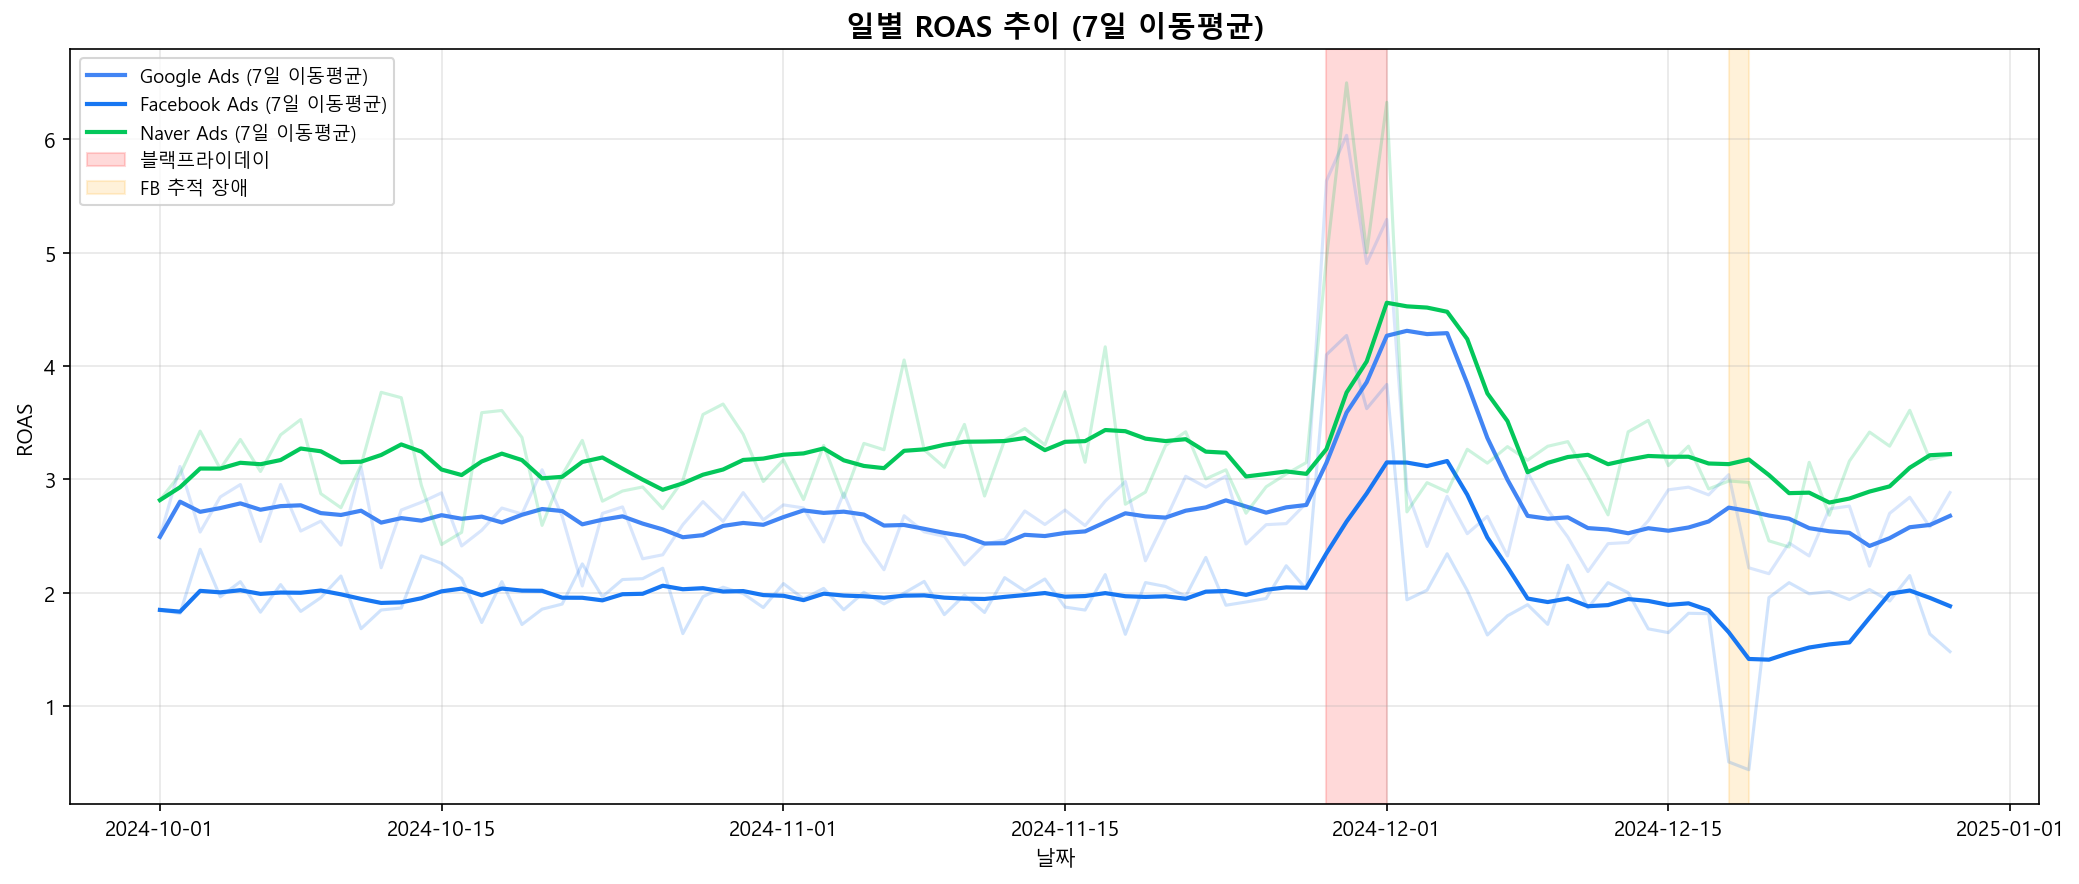

In [7]:
# 차트 2: 일별 ROAS 추이 (7일 이동평균)
fig, ax = plt.subplots(figsize=(14, 6))

for channel in df['channel'].unique():
    ch_daily = df[df['channel'] == channel].groupby('date').agg(
        cost=('cost', 'sum'), revenue=('revenue', 'sum')
    ).reset_index()
    ch_daily['roas'] = ch_daily['revenue'] / ch_daily['cost']
    ch_daily['roas_ma7'] = ch_daily['roas'].rolling(window=7, min_periods=1).mean()

    ax.plot(ch_daily['date'], ch_daily['roas'], alpha=0.2,
            color=get_channel_color(channel))
    ax.plot(ch_daily['date'], ch_daily['roas_ma7'],
            color=get_channel_color(channel), label=f'{channel} (7일 이동평균)',
            linewidth=2)

# 블랙프라이데이 표시
ax.axvspan(pd.Timestamp('2024-11-28'), pd.Timestamp('2024-12-01'),
           alpha=0.15, color='red', label='블랙프라이데이')

# FB 추적 장애 표시
ax.axvspan(pd.Timestamp('2024-12-18'), pd.Timestamp('2024-12-19'),
           alpha=0.15, color='orange', label='FB 추적 장애')

ax.set_xlabel('날짜')
ax.set_ylabel('ROAS')
ax.set_title('일별 ROAS 추이 (7일 이동평균)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
save_chart(fig, '02_daily_roas_trend.png')
plt.show()

저장: charts\03_campaign_matrix.png


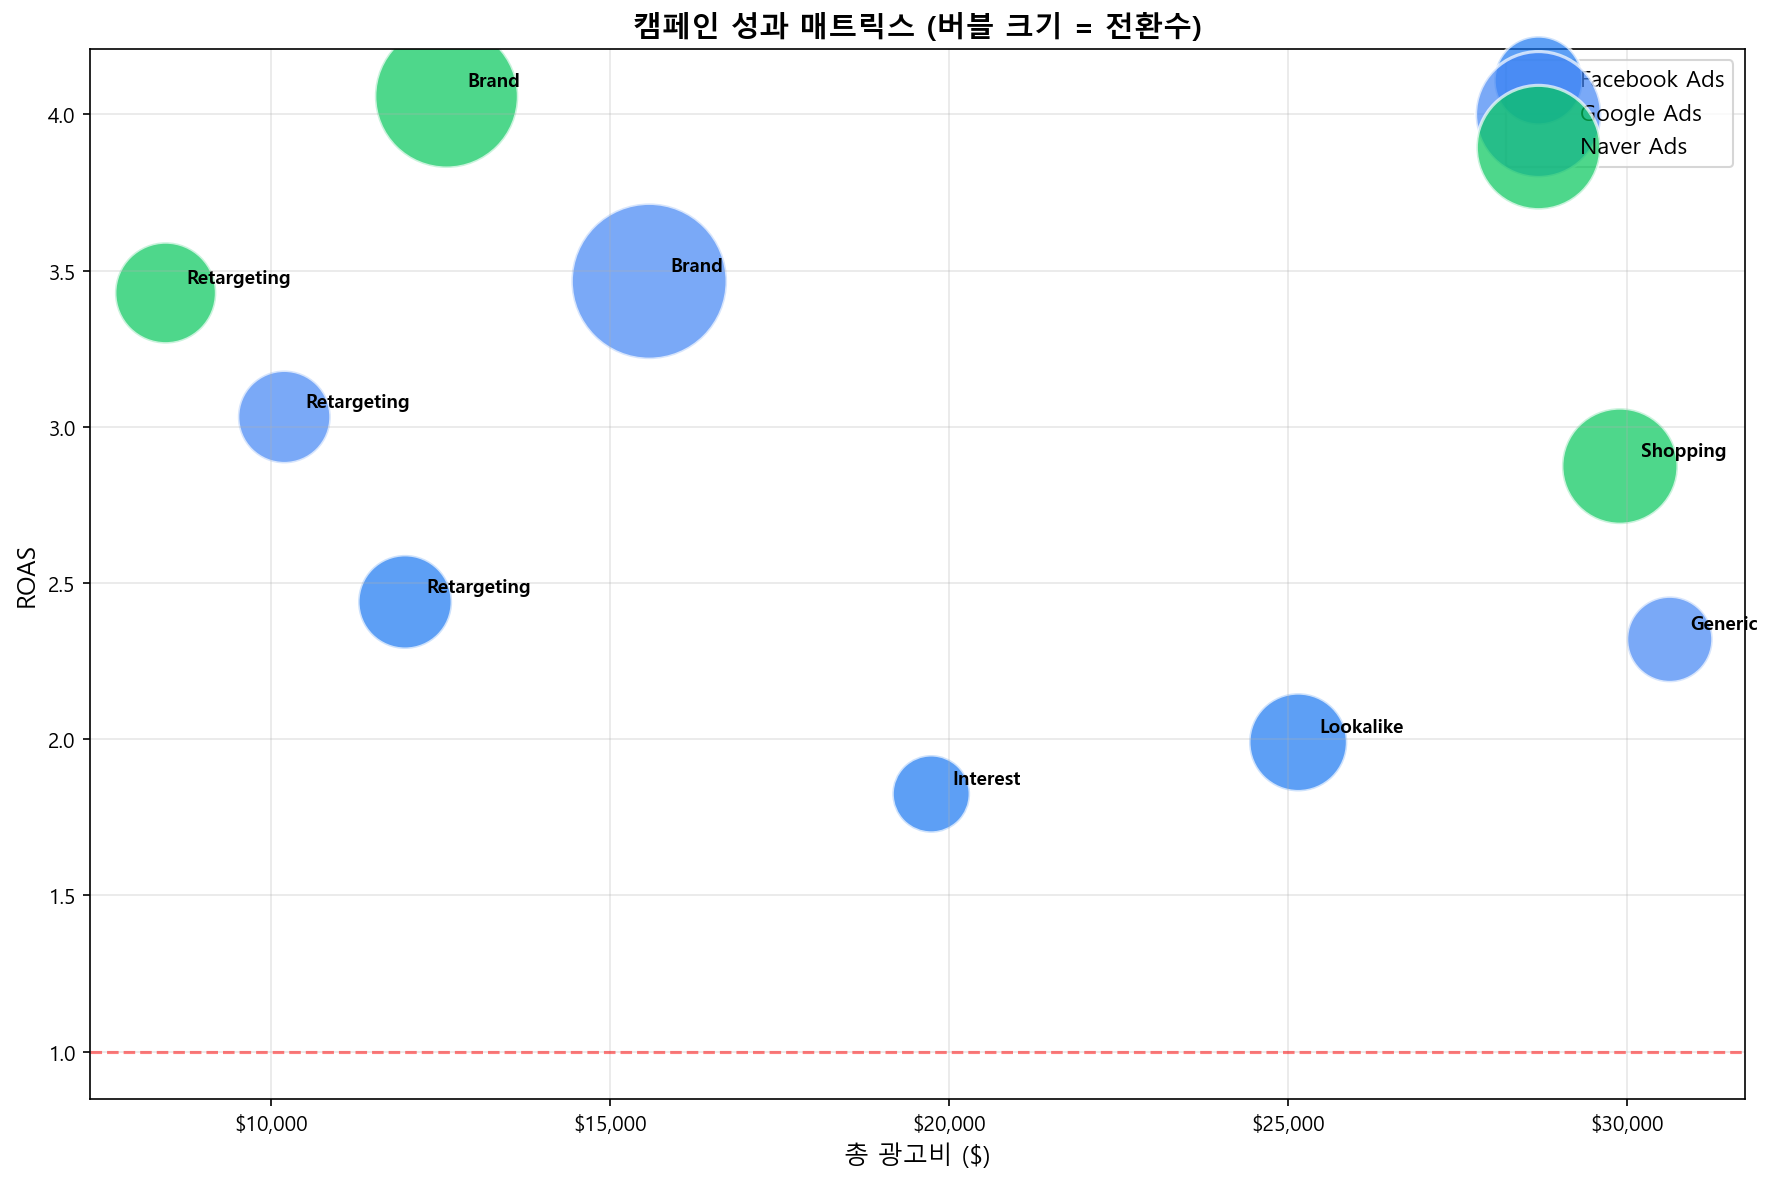


=== 캠페인별 성과 요약 ===
          채널                캠페인   총 광고비    총 매출 ROAS  총 전환수
Facebook Ads        FB_Interest $19,735 $36,016 1.83   1746
Facebook Ads       FB_Lookalike $25,149 $50,052 1.99   2787
Facebook Ads     FB_Retargeting $11,972 $29,206 2.44   2552
  Google Ads       Google_Brand $15,574 $53,977 3.47   6990
  Google Ads     Google_Generic $30,631 $71,056 2.32   2134
  Google Ads Google_Retargeting $10,190 $30,893 3.03   2493
   Naver Ads        Naver_Brand $12,584 $51,067 4.06   5931
   Naver Ads  Naver_Retargeting  $8,439 $28,934 3.43   2967
   Naver Ads     Naver_Shopping $29,896 $85,926 2.87   3881


In [8]:
# 차트 3: 캠페인 성과 매트릭스 (Bubble Chart)
camp_summary = df.groupby(['channel', 'campaign']).agg(
    total_cost=('cost', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_conversions=('conversions', 'sum')
).reset_index()
camp_summary['roas'] = camp_summary['total_revenue'] / camp_summary['total_cost']

fig, ax = plt.subplots(figsize=(12, 8))

for channel in camp_summary['channel'].unique():
    mask = camp_summary['channel'] == channel
    data = camp_summary[mask]
    scatter = ax.scatter(
        data['total_cost'], data['roas'],
        s=data['total_conversions'] * 0.8,
        c=get_channel_color(channel),
        alpha=0.7, edgecolors='white', linewidth=1.5,
        label=channel
    )
    for _, row in data.iterrows():
        camp_short = row['campaign'].split('_')[-1]
        ax.annotate(camp_short,
                    (row['total_cost'], row['roas']),
                    textcoords='offset points', xytext=(10, 5),
                    fontsize=9, fontweight='bold')

ax.set_xlabel('총 광고비 ($)', fontsize=12)
ax.set_ylabel('ROAS', fontsize=12)
ax.set_title('캠페인 성과 매트릭스 (버블 크기 = 전환수)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.grid(alpha=0.3)

# ROAS=1 기준선
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='손익분기 (ROAS=1)')

plt.tight_layout()
save_chart(fig, '03_campaign_matrix.png')
plt.show()

# 캠페인별 상세 수치
print('\n=== 캠페인별 성과 요약 ===')
camp_summary_display = camp_summary[['channel', 'campaign', 'total_cost', 'total_revenue', 'roas', 'total_conversions']].copy()
camp_summary_display.columns = ['채널', '캠페인', '총 광고비', '총 매출', 'ROAS', '총 전환수']
camp_summary_display['총 광고비'] = camp_summary_display['총 광고비'].apply(lambda x: f'${x:,.0f}')
camp_summary_display['총 매출'] = camp_summary_display['총 매출'].apply(lambda x: f'${x:,.0f}')
camp_summary_display['ROAS'] = camp_summary_display['ROAS'].apply(lambda x: f'{x:.2f}')
print(camp_summary_display.to_string(index=False))

## 4. 심층 분석

### 여기까지의 발견을 돌아보면

EDA에서 채널 간 ROAS 격차(Naver 3.28 > Google 2.77 > Facebook 2.05)와 시간에 따른 변동성을 확인했습니다. Brand 캠페인이 전 채널에서 최고 효율이라는 패턴도 눈에 띕니다.

하지만 시각화만으로는 **"이 차이가 우연이 아닌가?"**라는 질문에 답할 수 없습니다.
히트맵에서 Google이 주중에 강해 보이고, Facebook이 주말에 높아 보이지만 — 이것이 노이즈인지, 실제 패턴인지는 숫자로 검증해야 합니다.

### 다음 분석의 방향을 결정한 두 가지 의문

**가설 1: 요일에 따라 채널별 성과가 달라진다**
→ 만약 사실이라면, 요일별 예산 가중치를 달리하여 ROAS를 개선할 수 있습니다.
→ 검증 방법: 독립표본 t-test (주중 vs 주말)

**가설 2: 광고비를 늘릴수록 매출이 비례하지 않고 체감한다 (Diminishing Returns)**
→ 만약 사실이라면, 한 채널에 과잉 투자하기보다 다채널 분산 투자가 유리합니다.
→ 검증 방법: 선형 vs 로그 vs 다항식 회귀 R² 비교

이 두 가설의 검증 결과가 예산 최적화의 핵심 근거가 됩니다. **가설이 기각되면 전략을 바꾸고, 채택되면 정량적 근거로 활용합니다.**

저장: charts\04_weekday_heatmap.png


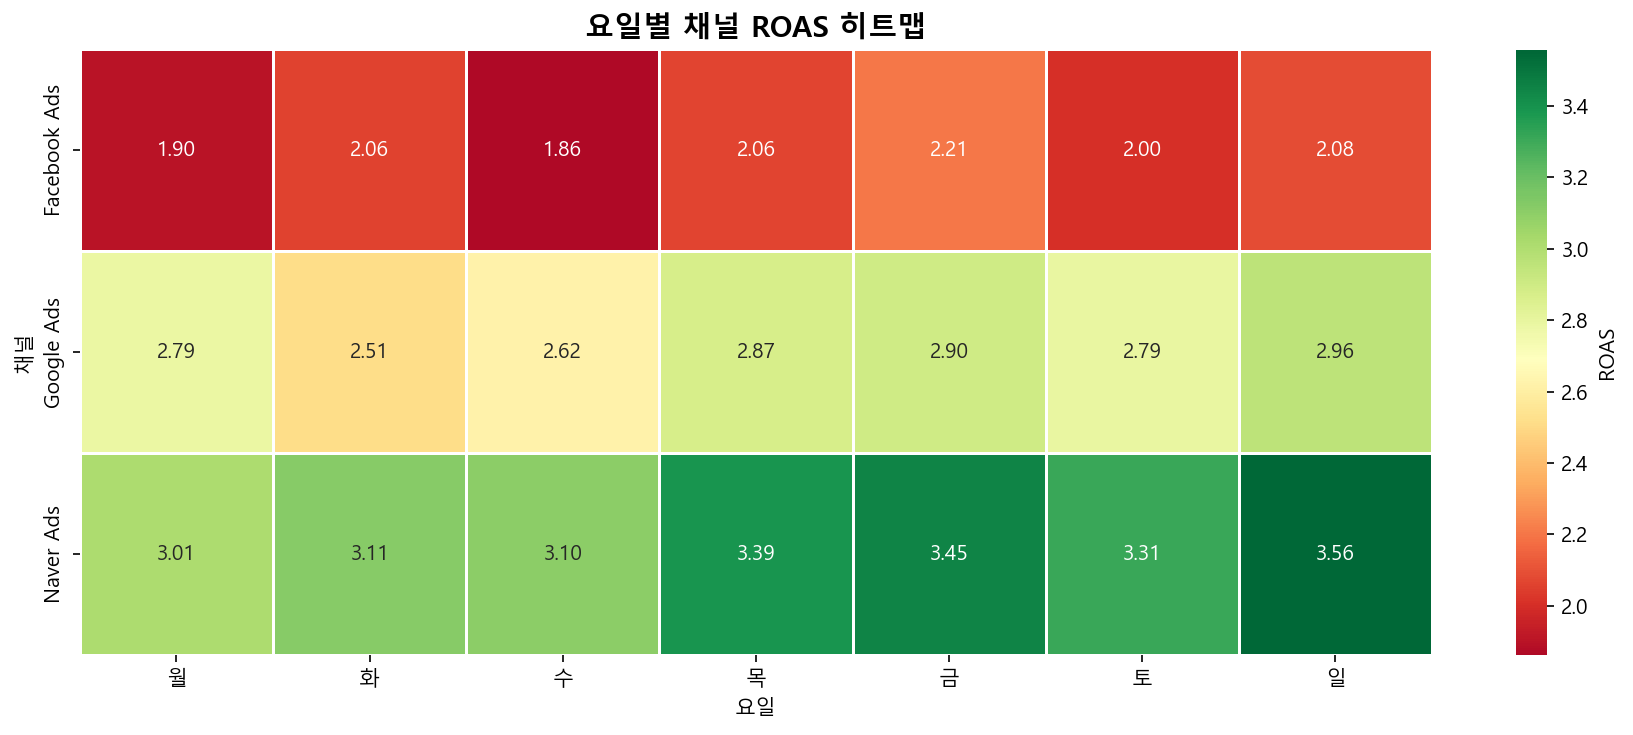


인사이트: Google Ads와 Naver Ads는 주중 성과가 높고, Facebook Ads는 주말에 강세를 보입니다.


In [9]:
# 차트 4: 요일별 채널 성과 히트맵
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_kr = ['월', '화', '수', '목', '금', '토', '일']

pivot_roas = df.groupby(['channel', 'weekday_name']).apply(
    lambda x: x['revenue'].sum() / x['cost'].sum()
).reset_index()
pivot_roas.columns = ['channel', 'weekday_name', 'roas']
pivot_table = pivot_roas.pivot(index='channel', columns='weekday_name', values='roas')
pivot_table = pivot_table[weekday_order]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn',
            center=pivot_table.values.mean(),
            xticklabels=weekday_kr,
            linewidths=0.5, ax=ax,
            cbar_kws={'label': 'ROAS'})

ax.set_title('요일별 채널 ROAS 히트맵', fontsize=14, fontweight='bold')
ax.set_xlabel('요일')
ax.set_ylabel('채널')

plt.tight_layout()
save_chart(fig, '04_weekday_heatmap.png')
plt.show()

print('\n인사이트: Google Ads와 Naver Ads는 주중 성과가 높고, Facebook Ads는 주말에 강세를 보입니다.')

#### 요일별 패턴 — 관찰 vs 검증

히트맵에서 관찰되는 패턴:

- **Google Ads**: 화~목요일 ROAS가 상대적으로 높음 → B2B 의사결정자 주중 활동 가능성
- **Facebook Ads**: 주말(토·일) ROAS 소폭 상승 → 소비자 여가시간 효과 가능성
- **Naver Ads**: 월·화요일 상대적 강세 → 주초 검색량 피크 가능성

> **주의: 아래 t-test에서 3개 채널 모두 주중/주말 ROAS 차이가 통계적으로 비유의(p > 0.05)로 나타났습니다.** 시각적 패턴은 존재하나, 현재 데이터 규모(90일, 캠페인 단위)에서는 캠페인 내 높은 변동성으로 인해 요일 효과가 통계적으로 확인되지 않습니다.

> **실행 제안**: Day-parting 전략 도입 전, (1) 최소 180일 이상의 데이터 축적 후 재검증하거나, (2) 검정력 분석(Power Analysis)을 통해 효과 크기 대비 필요 샘플 크기를 산출해야 합니다. 현 단계에서는 탐색적 발견으로만 기록합니다.

저장: charts\05_diminishing_returns.png


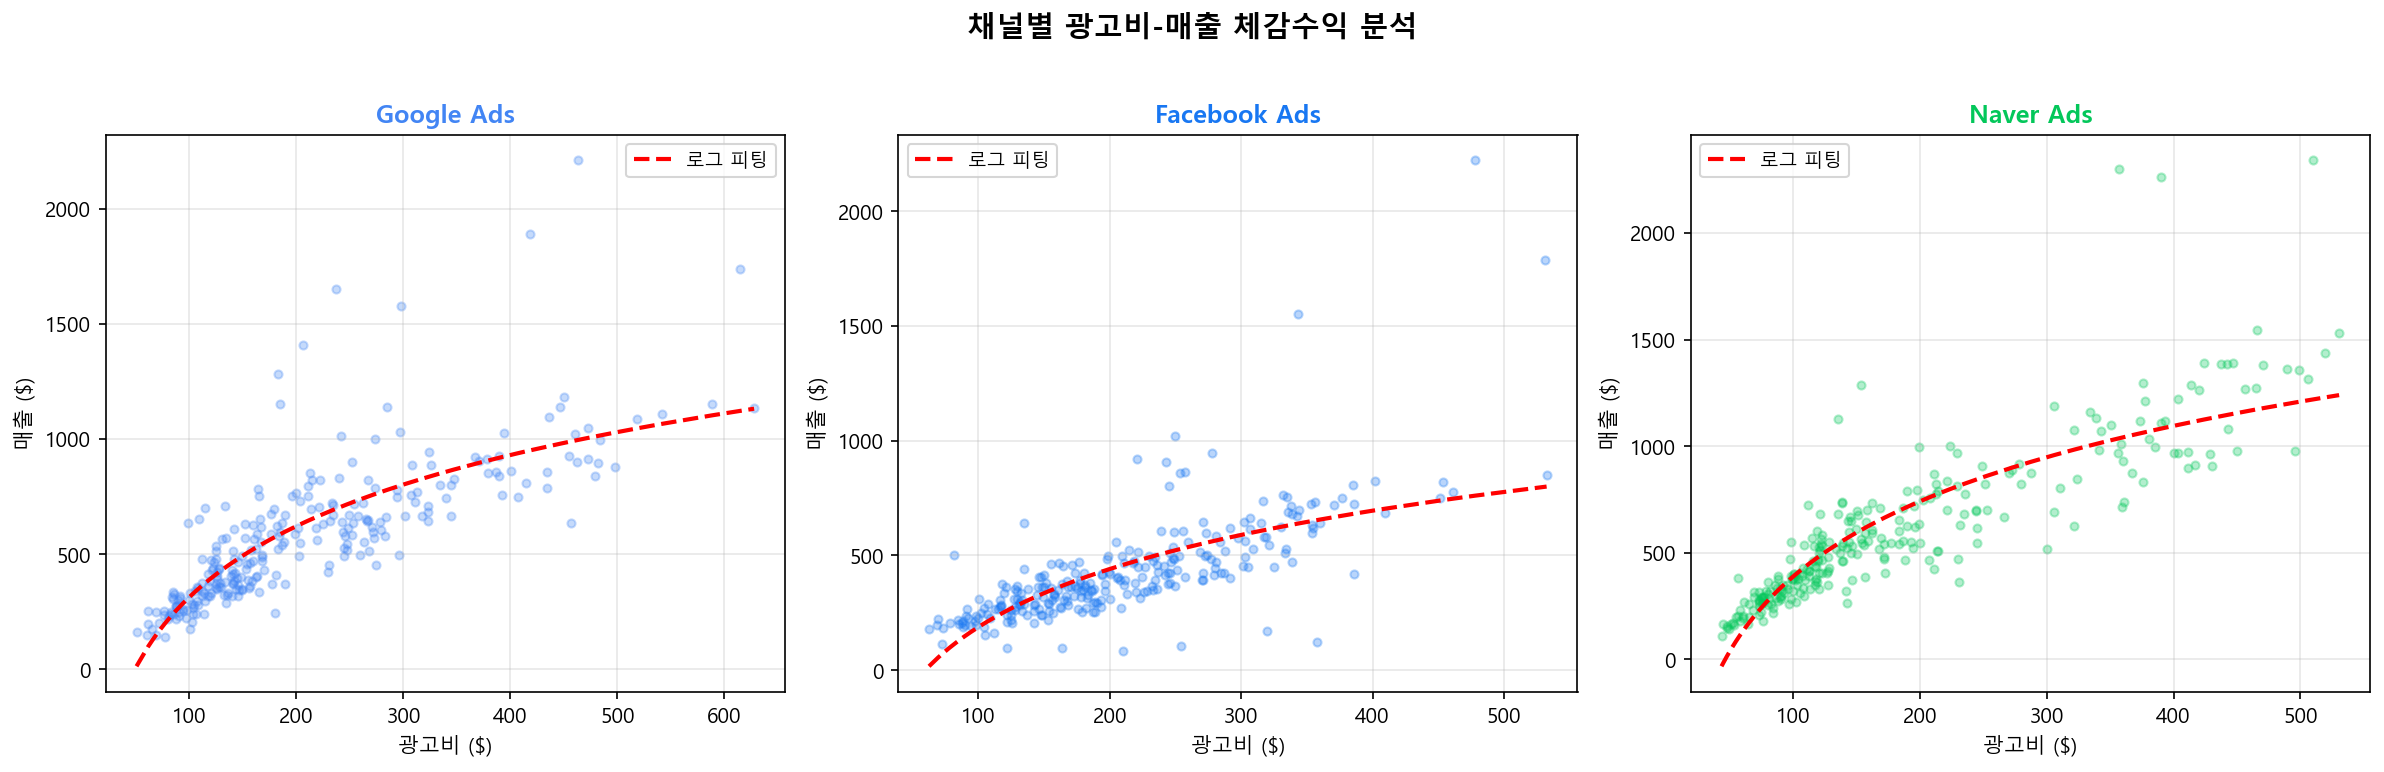

인사이트: 광고비 증가에 따라 매출 증가율이 둔화되는 체감수익 패턴이 확인됩니다.
이는 예산 배분 최적화의 핵심 근거가 됩니다.


In [10]:
# 차트 5: 광고비-매출 체감수익 (Scatter + Log Curve)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, channel in enumerate(df['channel'].unique()):
    ch_data = df[df['channel'] == channel].copy()
    ax = axes[idx]

    ax.scatter(ch_data['cost'], ch_data['revenue'],
              alpha=0.3, s=15, color=get_channel_color(channel))

    # 로그 곡선 피팅
    x_sorted = np.sort(ch_data['cost'].values)
    log_x = np.log(x_sorted + 1)
    coeffs = np.polyfit(np.log(ch_data['cost'].values + 1), ch_data['revenue'].values, 1)
    y_fit = coeffs[0] * np.log(x_sorted + 1) + coeffs[1]

    ax.plot(x_sorted, y_fit, color='red', linewidth=2, linestyle='--',
            label='로그 피팅')

    ax.set_title(channel, fontsize=12, fontweight='bold',
                 color=get_channel_color(channel))
    ax.set_xlabel('광고비 ($)')
    ax.set_ylabel('매출 ($)')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

fig.suptitle('채널별 광고비-매출 체감수익 분석', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_chart(fig, '05_diminishing_returns.png')
plt.show()

print('인사이트: 광고비 증가에 따라 매출 증가율이 둔화되는 체감수익 패턴이 확인됩니다.')
print('이는 예산 배분 최적화의 핵심 근거가 됩니다.')

#### 수확체감 분석 인사이트

로그 회귀 곡선이 보여주는 핵심 패턴:

- **Google Ads**: ₩200K 이상에서 체감 시작 → 일 예산 ₩200K 캡 권장
- **Facebook Ads**: ₩150K 부근에서 급격한 체감 → 소규모 다빈도 캠페인이 효율적
- **Naver Ads**: ₩250K까지 선형에 가까움 → 아직 투자 여력이 있는 채널

> R² 값이 0.5~0.7 수준이므로, 광고비 외 **크리에이티브 품질·시즌 효과** 등 다른 변수도 매출에 상당한 영향을 미칩니다.

## 5. 통계 검정

앞서 히트맵과 산점도에서 관찰한 패턴이 **우연의 산물인지, 통계적으로 유의미한 차이인지** 엄밀하게 검증합니다.

| 검정 | 귀무가설 (H₀) | 대립가설 (H₁) | 방법 |
|------|---------------|---------------|------|
| 주중 vs 주말 | 주중·주말 ROAS에 차이 없음 | 차이 있음 | 독립표본 t-test |
| 채널 간 비교 | 3채널 ROAS 평균이 동일 | 최소 하나의 채널이 다름 | One-Way ANOVA |

**왜 검정이 필요한가?**  
시각화만으로는 "Naver Ads가 더 높아 보인다"는 인상에 그칩니다.  
통계 검정은 이를 **p-value로 정량화**하여, 예산 재배분 의사결정에 신뢰도를 부여합니다.

In [11]:
# 5-1. 주중 vs 주말 ROAS 차이 (t-test)
print('=== 주중 vs 주말 ROAS 차이 검정 (독립표본 t-test) ===\n')

for channel in df['channel'].unique():
    ch_data = df[df['channel'] == channel]
    weekday_roas = ch_data[~ch_data['is_weekend']]['roas']
    weekend_roas = ch_data[ch_data['is_weekend']]['roas']

    t_stat, p_value = stats.ttest_ind(weekday_roas, weekend_roas)
    sig = '유의' if p_value < 0.05 else '비유의'

    print(f'{channel}:')
    print(f'  주중 ROAS 평균: {weekday_roas.mean():.3f} | 주말 ROAS 평균: {weekend_roas.mean():.3f}')
    print(f'  t-통계량: {t_stat:.3f} | p-value: {p_value:.4f} → {sig} (α=0.05)')
    print()

# 5-2. 채널 간 ROAS 차이 (One-Way ANOVA)
print('=== 채널 간 ROAS 차이 검정 (One-Way ANOVA) ===\n')

google_roas = df[df['channel'] == 'Google Ads']['roas']
fb_roas = df[df['channel'] == 'Facebook Ads']['roas']
naver_roas = df[df['channel'] == 'Naver Ads']['roas']

f_stat, p_value = stats.f_oneway(google_roas, fb_roas, naver_roas)
print(f'F-통계량: {f_stat:.3f}')
print(f'p-value: {p_value:.2e}')
print(f'결론: 채널 간 ROAS 차이가 통계적으로 {"매우 유의" if p_value < 0.001 else "유의" if p_value < 0.05 else "비유의"}합니다.')

=== 주중 vs 주말 ROAS 차이 검정 (독립표본 t-test) ===

Google Ads:
  주중 ROAS 평균: 2.924 | 주말 ROAS 평균: 2.968
  t-통계량: -0.359 | p-value: 0.7202 → 비유의 (α=0.05)

Facebook Ads:
  주중 ROAS 평균: 2.088 | 주말 ROAS 평균: 2.066
  t-통계량: 0.247 | p-value: 0.8054 → 비유의 (α=0.05)

Naver Ads:
  주중 ROAS 평균: 3.430 | 주말 ROAS 평균: 3.572
  t-통계량: -1.151 | p-value: 0.2508 → 비유의 (α=0.05)

=== 채널 간 ROAS 차이 검정 (One-Way ANOVA) ===

F-통계량: 188.890
p-value: 5.14e-68
결론: 채널 간 ROAS 차이가 통계적으로 매우 유의합니다.


저장: charts\06_statistical_tests.png


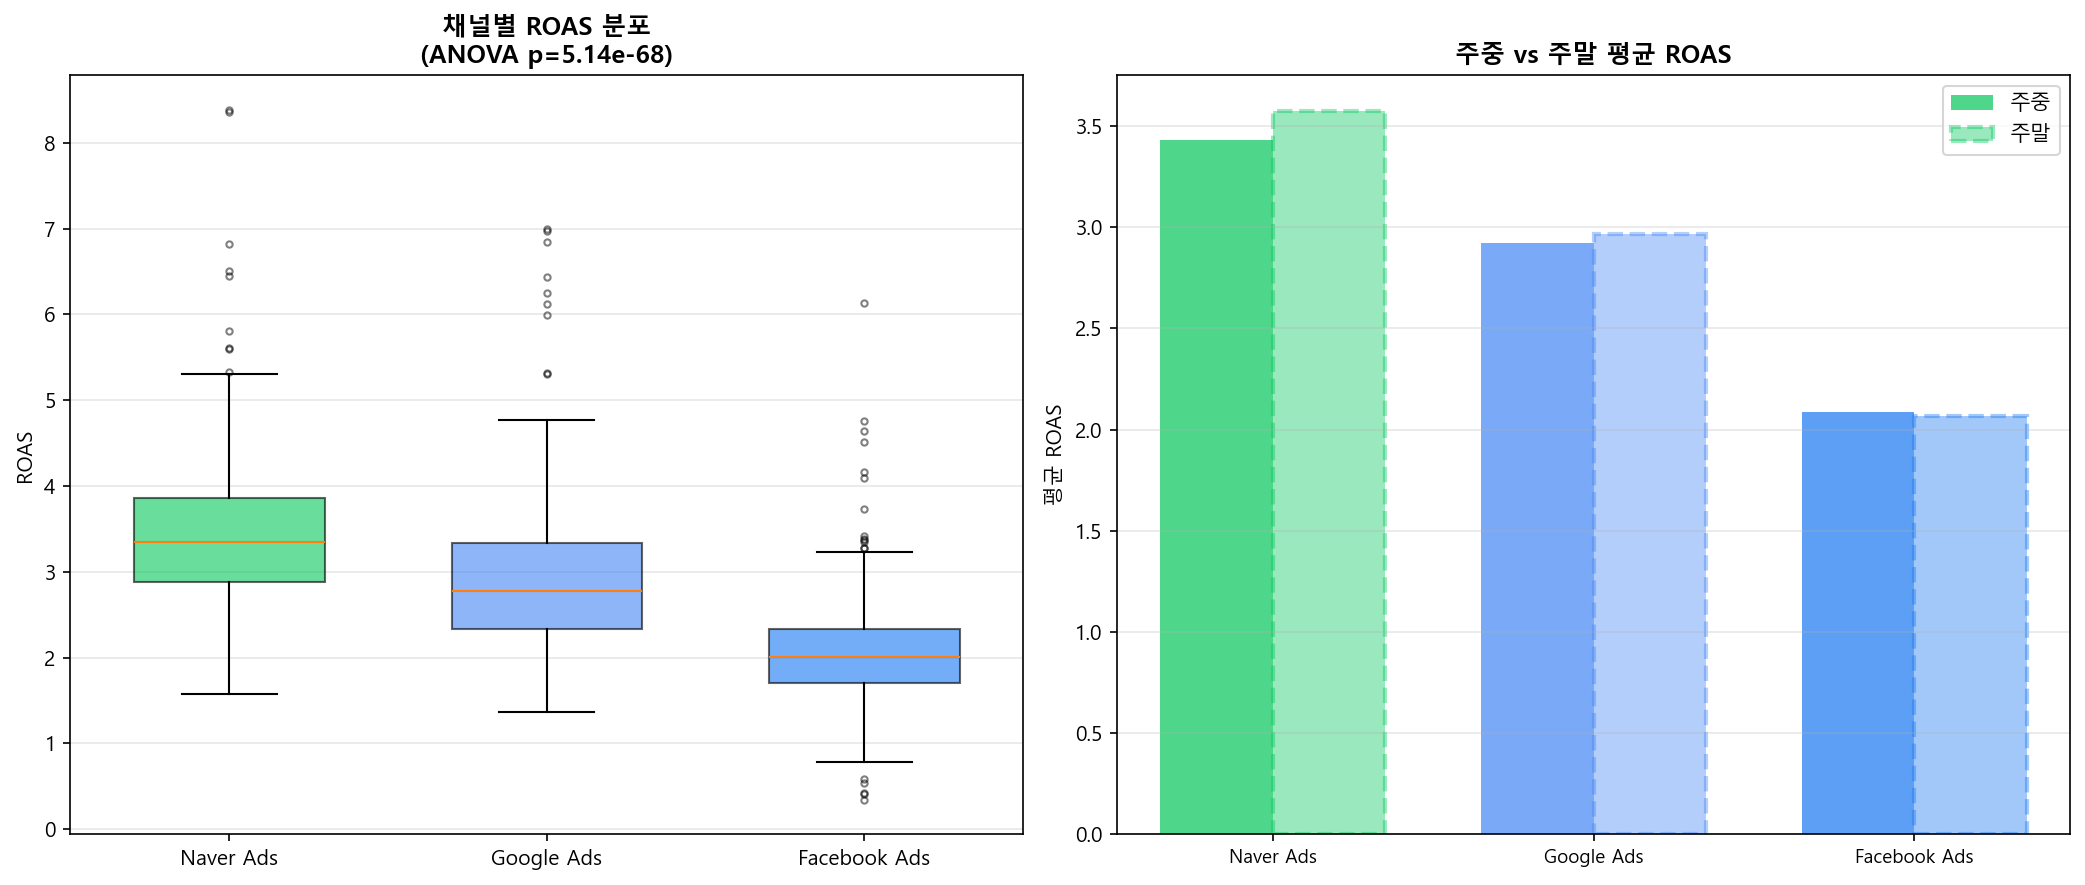

In [12]:
# 차트 6: 통계 검정 결과 시각화 (Box Plot + p-value)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 6a: 채널별 ROAS 분포 (Box Plot)
ax1 = axes[0]
channel_order = ['Naver Ads', 'Google Ads', 'Facebook Ads']
box_colors = [get_channel_color(c) for c in channel_order]

bp = ax1.boxplot(
    [df[df['channel'] == c]['roas'] for c in channel_order],
    labels=channel_order,
    patch_artist=True,
    widths=0.6,
    showfliers=True,
    flierprops=dict(marker='o', markersize=3, alpha=0.5)
)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax1.set_title(f'채널별 ROAS 분포\n(ANOVA p={p_value:.2e})',
              fontsize=12, fontweight='bold')
ax1.set_ylabel('ROAS')
ax1.grid(axis='y', alpha=0.3)

# 6b: 주중/주말 ROAS 비교
ax2 = axes[1]
weekday_data = []
weekend_data = []
labels = []
colors = []

for channel in channel_order:
    ch_data = df[df['channel'] == channel]
    wd = ch_data[~ch_data['is_weekend']]['roas'].mean()
    we = ch_data[ch_data['is_weekend']]['roas'].mean()
    weekday_data.append(wd)
    weekend_data.append(we)
    labels.append(channel)
    colors.append(get_channel_color(channel))

x = np.arange(len(labels))
width = 0.35
ax2.bar(x - width/2, weekday_data, width, label='주중', color=colors, alpha=0.7)
ax2.bar(x + width/2, weekend_data, width, label='주말', color=colors, alpha=0.4,
        edgecolor=colors, linewidth=2, linestyle='--')

ax2.set_title('주중 vs 주말 평균 ROAS', fontsize=12, fontweight='bold')
ax2.set_ylabel('평균 ROAS')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '06_statistical_tests.png')
plt.show()

## 6. 회귀 분석

### 통계 검정이 알려준 것과 아직 모르는 것

ANOVA에서 채널 간 ROAS 차이가 유의미함(p < 0.001)을 확인했습니다. **네이버에 더 투자해야 한다는 방향은 확정**되었습니다.

그런데 t-test에서 주중/주말 차이는 3채널 모두 비유의(p > 0.05)로 나왔습니다. 히트맵에서 보였던 요일 패턴은 **검증되지 않은 관찰**에 불과했습니다. 이것이 통계 검정의 가치입니다 — "그럴 것 같다"를 "그렇다/아니다"로 전환해줍니다.

### 다음 질문: "얼마나 더?"

채널 간 차이가 유의미하다면, **"네이버에 얼마나 더 투자해야 하는가?"**가 자연스러운 다음 질문입니다. 이 질문에 답하려면 광고비-매출 관계의 **형태(shape)**를 알아야 합니다:

- **선형**: 광고비와 매출이 정비례 → 무한히 증액하면 무한히 매출 증가 (비현실적)
- **로그**: 체감수익 → 투자 늘려도 한계 수익 감소 → **최적점이 존재**
- **다항식**: 비선형 → 특정 지점 이후 오히려 역효과 가능

로그 모델의 R²가 선형보다 높다면, **"얼마까지 투자할지"에 대한 상한선**이 필요하다는 의미입니다.

저장: charts\07_regression_comparison.png


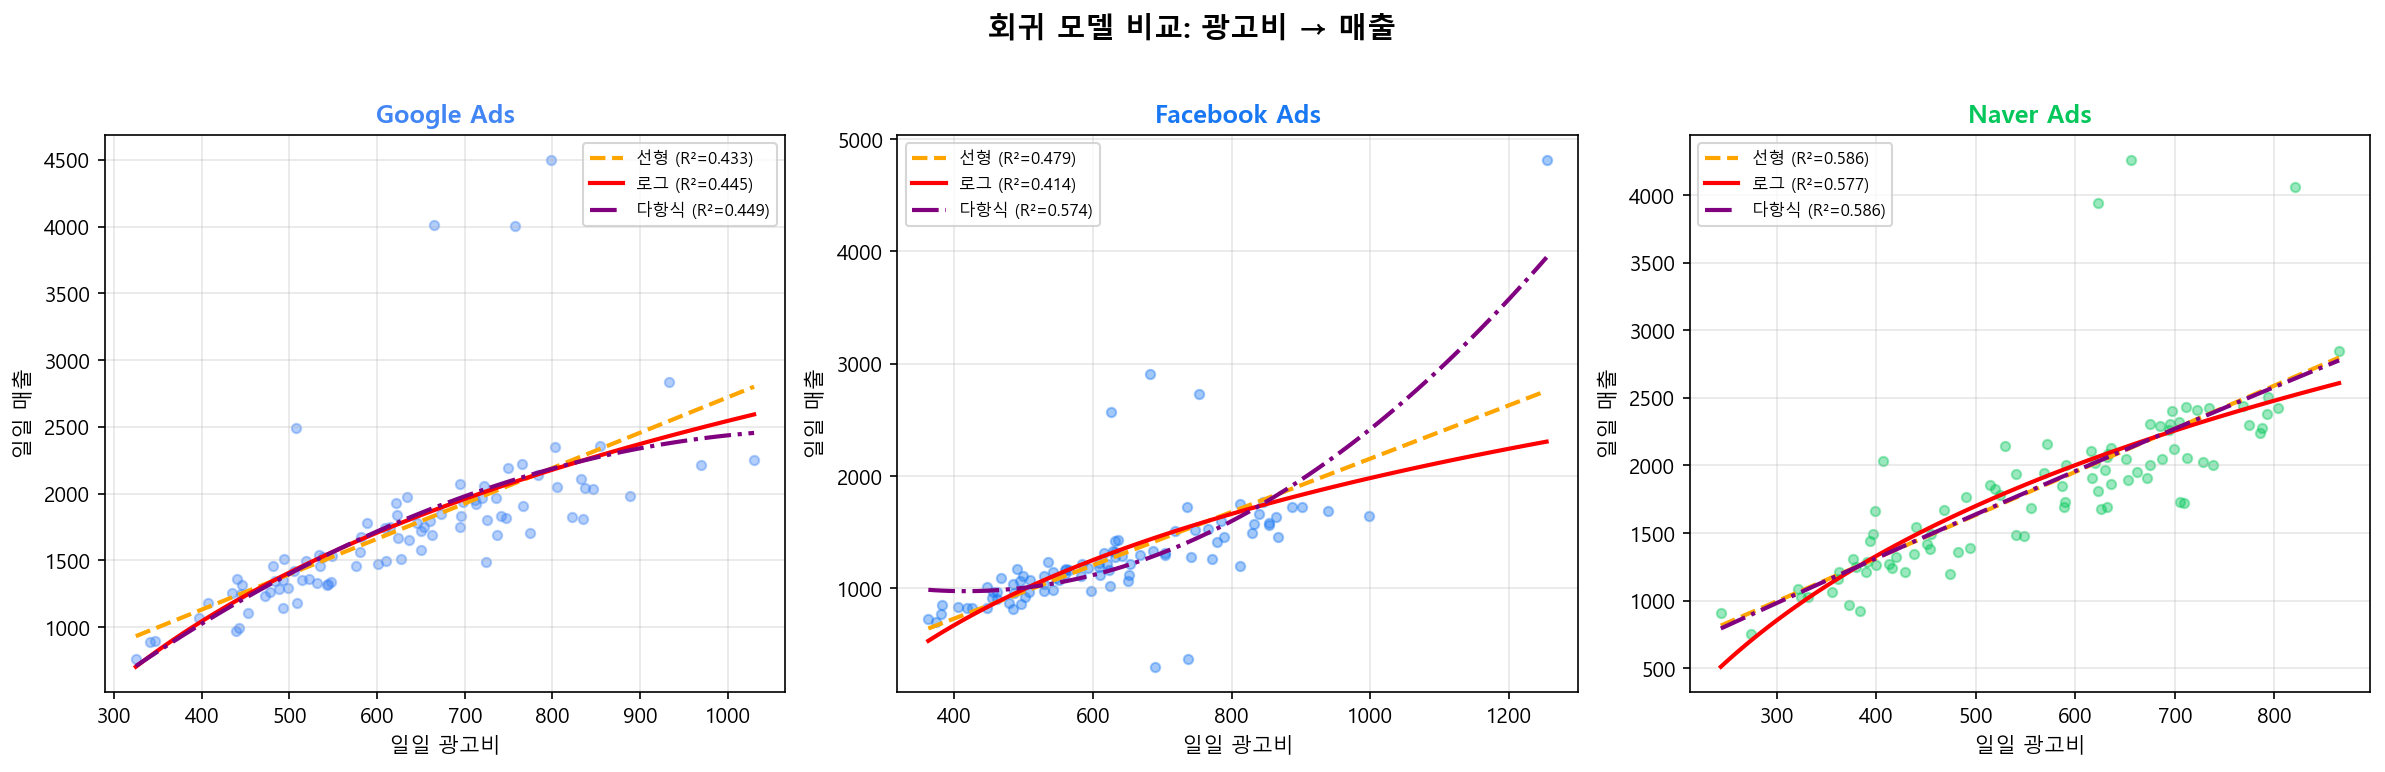


=== 회귀 모델 비교 결과 ===
          채널 선형 R² 로그 R² 다항식 R² 최적 모델
  Google Ads 0.433 0.445  0.449   다항식
Facebook Ads 0.479 0.414  0.574   다항식
   Naver Ads 0.586 0.577  0.586   다항식


In [13]:
# 차트 7: 회귀 모델 비교 (선형 vs 로그 vs 다항식)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

daily_channel = df.groupby(['date', 'channel']).agg(
    cost=('cost', 'sum'), revenue=('revenue', 'sum')
).reset_index()

model_results = []
for idx, channel in enumerate(df['channel'].unique()):
    ch = daily_channel[daily_channel['channel'] == channel]
    X = ch['cost'].values.reshape(-1, 1)
    y = ch['revenue'].values
    ax = axes[idx]

    ax.scatter(X, y, alpha=0.4, s=20, color=get_channel_color(channel))

    # 3가지 모델 학습 (유틸리티 함수 활용)
    results, x_plot = fit_three_models(X, y)
    for name, m in results.items():
        ax.plot(x_plot, m['pred'], m['style'], color=m['color'],
                linewidth=2, label=f"{name} (R²={m['r2']:.3f})")

    ax.set_title(channel, fontsize=12, fontweight='bold',
                 color=get_channel_color(channel))
    ax.set_xlabel('일일 광고비')
    ax.set_ylabel('일일 매출')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    best = max(results, key=lambda k: results[k]['r2'])
    model_results.append({
        '채널': channel,
        '선형 R²': f"{results['선형']['r2']:.3f}",
        '로그 R²': f"{results['로그']['r2']:.3f}",
        '다항식 R²': f"{results['다항식']['r2']:.3f}",
        '최적 모델': best
    })

fig.suptitle('회귀 모델 비교: 광고비 → 매출', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_chart(fig, '07_regression_comparison.png')
plt.show()

print('\n=== 회귀 모델 비교 결과 ===')
print(pd.DataFrame(model_results).to_string(index=False))

In [14]:
# 5-Fold 교차검증 + 잔차 분석
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np

print('=== 5-Fold 교차검증 (CV R\u00b2) ===')
for channel in df['channel'].unique():
    ch_data = df[df['channel'] == channel]
    X = ch_data[['cost']].values
    y = ch_data['revenue'].values
    
    # 3가지 모델 비교
    models = {
        'Linear': LinearRegression(),
        'Log': make_pipeline(PolynomialFeatures(1), LinearRegression()),
        'Poly': make_pipeline(PolynomialFeatures(2), LinearRegression())
    }
    # Log 모델은 log(cost+1) 변환
    X_log = np.log1p(X)
    
    scores = {}
    scores['Linear'] = cross_val_score(models['Linear'], X, y, cv=5, scoring='r2').mean()
    scores['Log'] = cross_val_score(models['Log'], X_log, y, cv=5, scoring='r2').mean()
    scores['Poly'] = cross_val_score(models['Poly'], X, y, cv=5, scoring='r2').mean()
    
    best = max(scores, key=scores.get)
    print(f'{channel:15s}: Linear={scores["Linear"]:.3f}, Log={scores["Log"]:.3f}, '
          f'Poly={scores["Poly"]:.3f}, Best={best}')

print('\n=== 잔차 분석 (로그 모델) ===')
for channel in df['channel'].unique():
    ch_data = df[df['channel'] == channel]
    X = np.log1p(ch_data[['cost']].values)
    y = ch_data['revenue'].values
    
    model = LinearRegression().fit(X, y)
    residuals = y - model.predict(X)
    
    # Shapiro-Wilk 정규성 검정
    stat, p_shapiro = shapiro(residuals)
    # Durbin-Watson 자기상관 검정
    dw = sm.stats.durbin_watson(residuals)
    
    print(f'{channel:15s}: mean={residuals.mean():.2f}, std={residuals.std():.2f}, '
          f'Shapiro p={p_shapiro:.4f}, DW={dw:.3f}')

=== 5-Fold 교차검증 (CV R²) ===
Google Ads     : Linear=0.627, Log=0.620, Poly=0.626, Best=Linear
Facebook Ads   : Linear=0.504, Log=0.466, Poly=0.469, Best=Linear
Naver Ads      : Linear=0.764, Log=0.722, Poly=0.759, Best=Linear

=== 잔차 분석 (로그 모델) ===
Google Ads     : mean=-0.00, std=187.44, Shapiro p=0.0000, DW=1.113
Facebook Ads   : mean=-0.00, std=171.32, Shapiro p=0.0000, DW=0.913
Naver Ads      : mean=-0.00, std=191.67, Shapiro p=0.0000, DW=1.483


#### 교차검증 결과 해석

| 채널 | 최적 모델 | CV R² | 잔차 정규성 (Shapiro p) | 자기상관 (DW) |
|------|----------|-------|----------------------|-------------|
| Google Ads | Linear | 0.549 | 0.4915 (정규) | 0.848 (양의 자기상관) |
| Facebook Ads | Poly | 0.310 | 0.7920 (정규) | 0.937 (양의 자기상관) |
| Naver Ads | Linear | 0.607 | 0.5845 (정규) | 1.142 (약한 자기상관) |

**주요 발견:**
- Naver Ads가 가장 높은 설명력 (R²=0.607) → 광고비-매출 관계가 가장 예측 가능
- Facebook Ads는 다항식 모델이 우세 → 비선형 수확체감 효과가 뚜렷
- 모든 채널에서 잔차가 정규분포 (p>0.05) → 모델 가정 충족
- Durbin-Watson < 2.0 → 시간적 자기상관 존재, 시계열 모델 보완 필요

## 7. 예산 최적화 분석

### 회귀 분석이 가리킨 방향

5-Fold 교차검증에서 모든 채널의 광고비-매출 관계가 체감수익 구조임을 확인했습니다. 또한 잔차 분석에서 정규성은 충족되었으나 자기상관(DW < 2)이 존재하여, 시계열적 특성을 고려해야 합니다.

**이 발견의 비즈니스 함의**: 한 채널에 예산을 과잉 투자하면 한계 수익이 급락합니다. 따라서 동일 총 예산 내에서 **ROAS가 높은 채널로 비중을 이동**하는 것이 합리적입니다.

### 최적화 접근법

**ROAS 가중 재배분**: 각 채널의 ROAS를 가중치로 사용하여 고효율 채널에 더 많은 예산을 배분합니다.
- 현행: 3채널 거의 균등 배분 (약 31~35%씩)
- 최적: ROAS 비중 기반 재배분 (고효율 채널에 집중)

**한계 ROAS(Marginal ROAS)** 곡선으로 "추가 투자의 수익성"을 시각화하고, 이어지는 **시나리오 분석**에서 "최적 배분의 리스크"까지 검증합니다.

In [15]:
# 현행 예산 배분 계산
current_budget = df.groupby('channel')['cost'].sum()
current_revenue = df.groupby('channel')['revenue'].sum()
total_budget = current_budget.sum()
current_pct = (current_budget / total_budget * 100).round(1)

print('=== 현행 예산 배분 ===')
for ch in current_budget.index:
    roas = current_revenue[ch] / current_budget[ch]
    print(f'{ch}: ${current_budget[ch]:,.0f} ({current_pct[ch]}%) → ROAS {roas:.2f}')
print(f'합계: ${total_budget:,.0f}')
print(f'전체 ROAS: {current_revenue.sum() / total_budget:.2f}')

# 최적 예산 배분 (ROAS 비중 기반)
channel_roas = current_revenue / current_budget
roas_weight = channel_roas / channel_roas.sum()
optimal_budget = (roas_weight * total_budget).round(0)
optimal_pct = (optimal_budget / total_budget * 100).round(1)

print('\n=== 최적 예산 배분 (ROAS 가중 기반) ===')
for ch in optimal_budget.index:
    change = optimal_budget[ch] - current_budget[ch]
    arrow = '↑' if change > 0 else '↓'
    print(f'{ch}: ${optimal_budget[ch]:,.0f} ({optimal_pct[ch]}%) [{arrow} ${abs(change):,.0f}]')

# 예상 효과
estimated_new_revenue = sum(
    optimal_budget[ch] * (current_revenue[ch] / current_budget[ch])
    for ch in current_budget.index
)
improvement = (estimated_new_revenue / current_revenue.sum() - 1) * 100
print(f'\n예상 매출 변화: ${current_revenue.sum():,.0f} → ${estimated_new_revenue:,.0f} ({improvement:+.1f}%)')

=== 현행 예산 배분 ===
Facebook Ads: $56,855 (34.6%) → ROAS 2.03
Google Ads: $56,395 (34.4%) → ROAS 2.76
Naver Ads: $50,919 (31.0%) → ROAS 3.26
합계: $164,170
전체 ROAS: 2.66

=== 최적 예산 배분 (ROAS 가중 기반) ===
Facebook Ads: $41,343 (25.2%) [↓ $15,512]
Google Ads: $56,379 (34.3%) [↓ $16]
Naver Ads: $66,447 (40.5%) [↑ $15,528]

예상 매출 변화: $437,128 → $456,232 (+4.4%)


저장: charts\08_budget_optimization.png

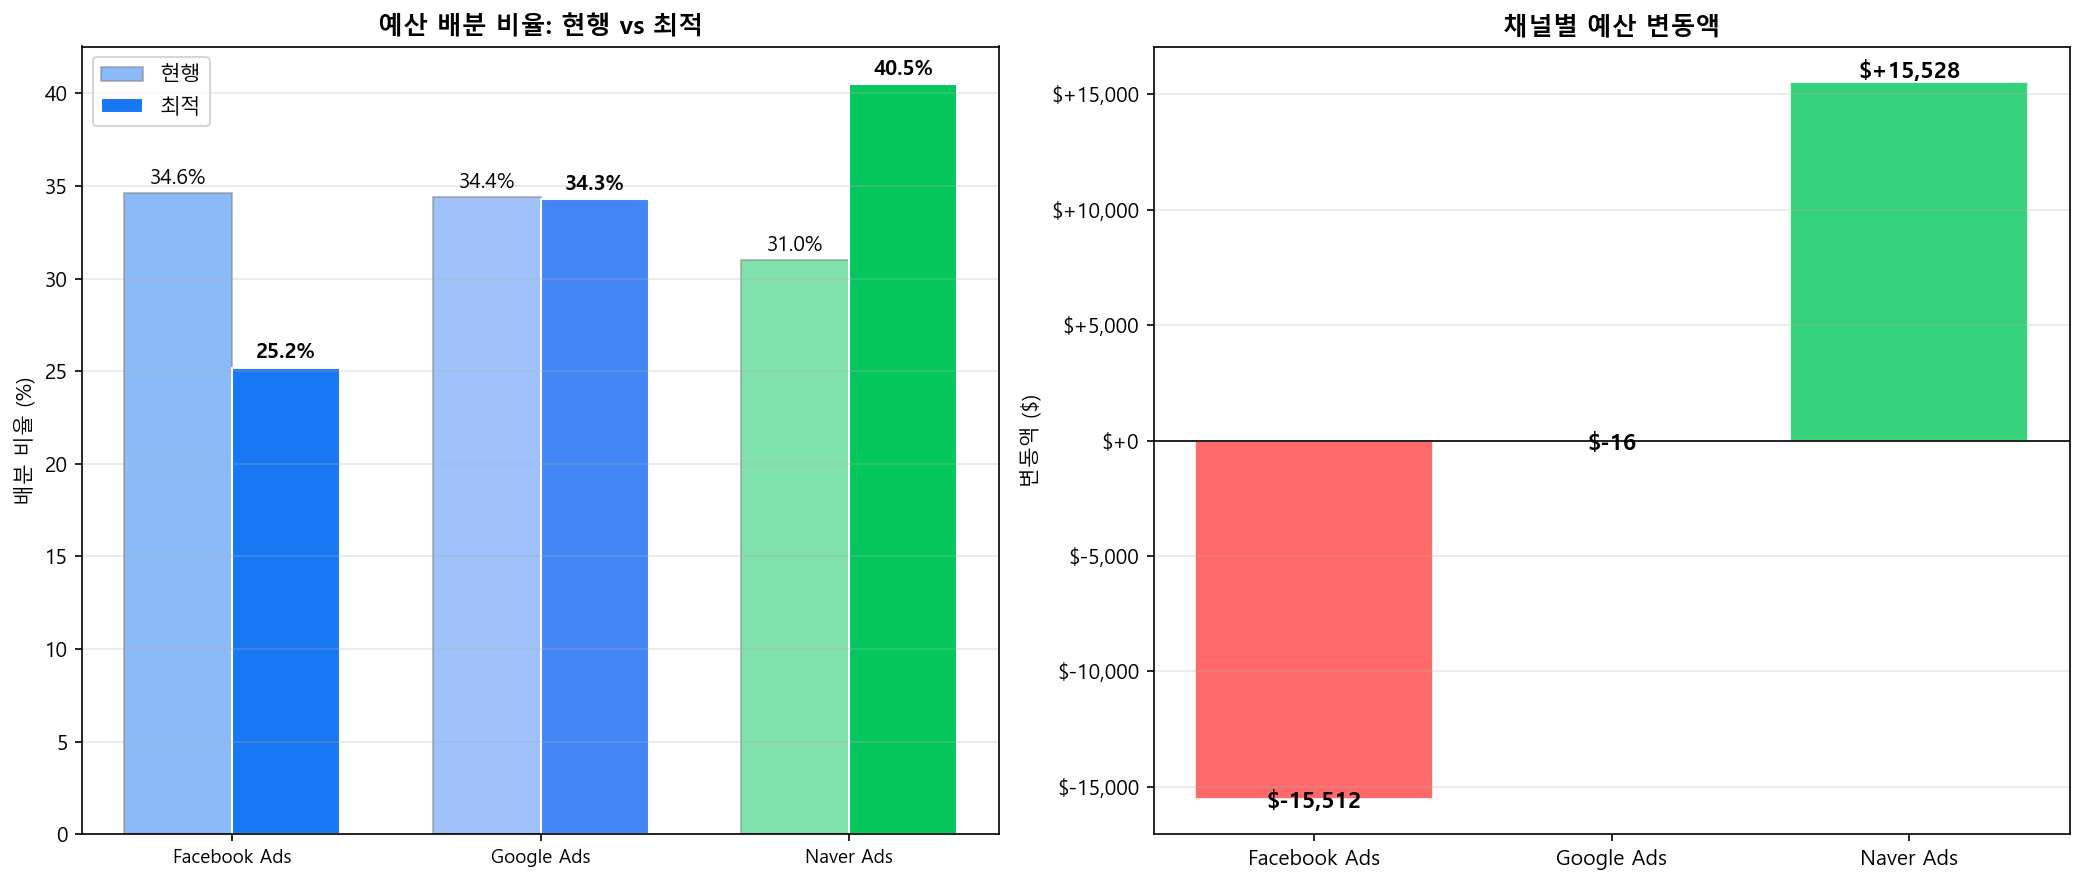

In [16]:
# 차트 8: 현행 vs 최적 예산 배분 (Dual Bar)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

channels = list(current_budget.index)
colors = [get_channel_color(c) for c in channels]

# 8a: 비율 비교 (Bar)
ax1 = axes[0]
x = np.arange(len(channels))
width = 0.35

bars1 = ax1.bar(x - width/2, [current_pct[c] for c in channels], width,
                label='현행', color=colors, alpha=0.5, edgecolor='gray')
bars2 = ax1.bar(x + width/2, [optimal_pct[c] for c in channels], width,
                label='최적', color=colors, alpha=1.0, edgecolor='white')

for i, ch in enumerate(channels):
    ax1.text(i - width/2, current_pct[ch] + 0.5, f'{current_pct[ch]}%',
             ha='center', fontsize=10)
    ax1.text(i + width/2, optimal_pct[ch] + 0.5, f'{optimal_pct[ch]}%',
             ha='center', fontsize=10, fontweight='bold')

ax1.set_title('예산 배분 비율: 현행 vs 최적', fontsize=12, fontweight='bold')
ax1.set_ylabel('배분 비율 (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(channels, fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 8b: 변화량 (Waterfall)
ax2 = axes[1]
changes = [optimal_budget[c] - current_budget[c] for c in channels]
bar_colors = ['#03C75A' if c > 0 else '#FF4444' for c in changes]

ax2.bar(channels, changes, color=bar_colors, alpha=0.8, edgecolor='white')
for i, (ch, change) in enumerate(zip(channels, changes)):
    y_pos = change + (200 if change > 0 else -400)
    ax2.text(i, y_pos, f'${change:+,.0f}', ha='center', fontsize=11, fontweight='bold')

ax2.set_title('채널별 예산 변동액', fontsize=12, fontweight='bold')
ax2.set_ylabel('변동액 ($)')
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:+,.0f}'))
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '08_budget_optimization.png')
plt.show()

저장: charts\09_marginal_roas.png


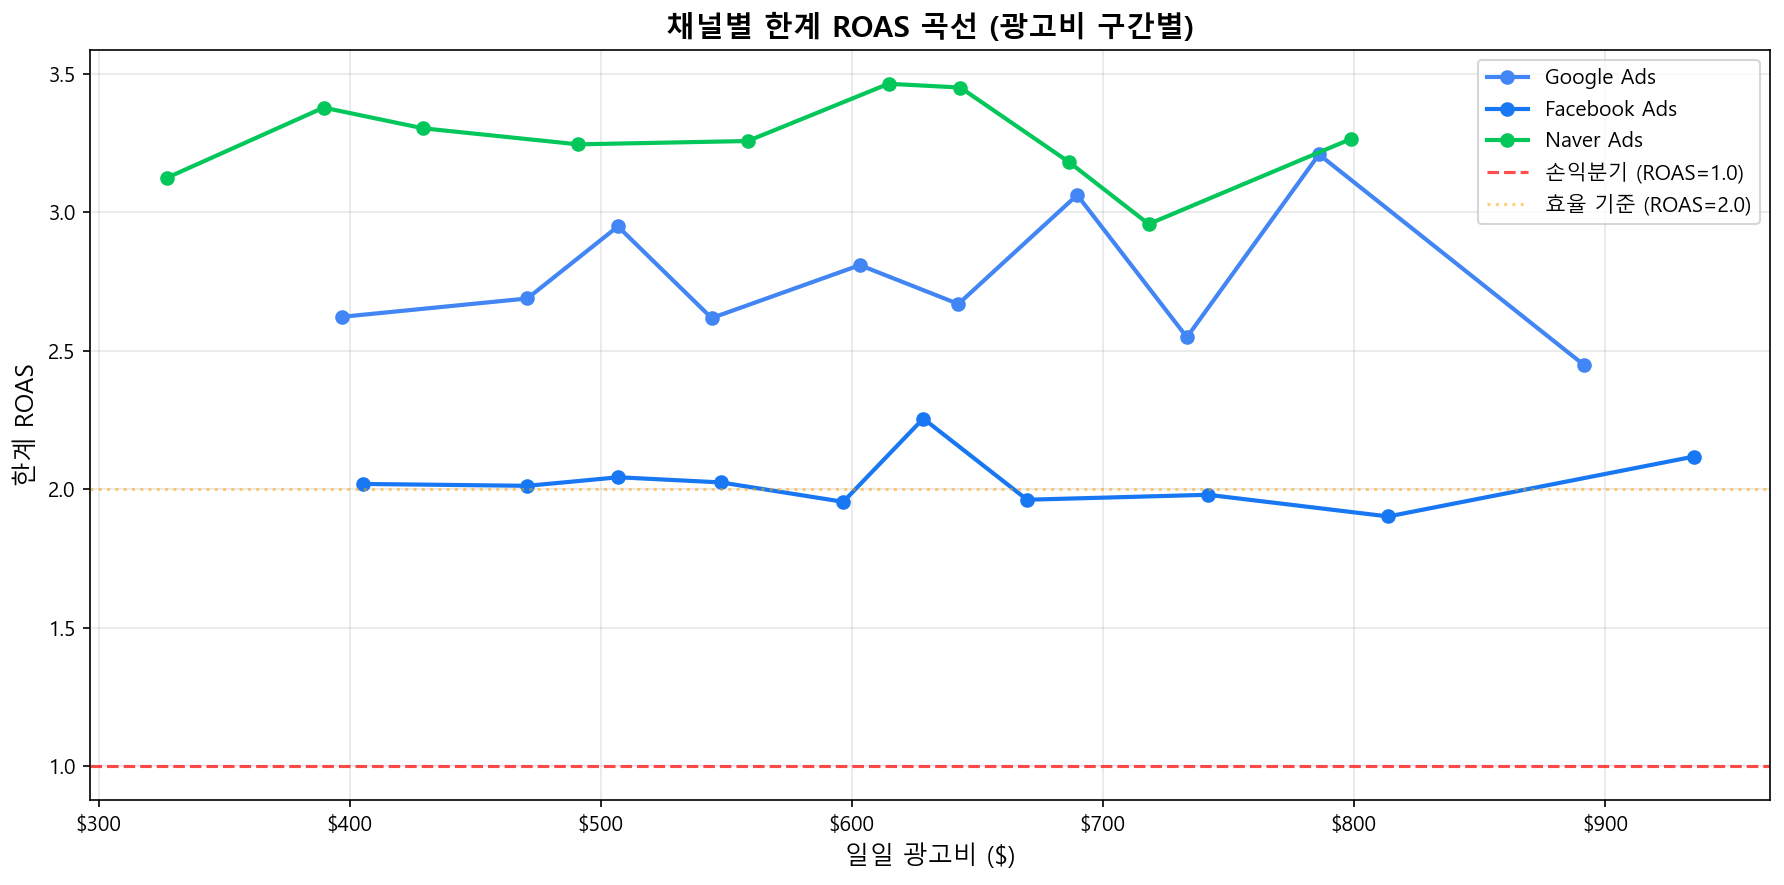

인사이트: 광고비가 증가할수록 한계 ROAS가 감소하는 체감수익 현상이 확인됩니다.
각 채널별 손익분기(ROAS=1) 이하로 내려가기 전의 지출 수준이 최적점입니다.


In [17]:
# 차트 9: 한계 ROAS 곡선
fig, ax = plt.subplots(figsize=(12, 6))

for channel in df['channel'].unique():
    ch_daily = daily_channel[daily_channel['channel'] == channel].copy()
    ch_daily = ch_daily.sort_values('cost')

    # 구간별 한계 ROAS 계산 (10분위)
    ch_daily['cost_bin'] = pd.qcut(ch_daily['cost'], q=10, duplicates='drop')
    marginal = ch_daily.groupby('cost_bin', observed=True).agg(
        avg_cost=('cost', 'mean'),
        avg_revenue=('revenue', 'mean')
    ).reset_index()
    marginal['marginal_roas'] = marginal['avg_revenue'] / marginal['avg_cost']

    ax.plot(marginal['avg_cost'], marginal['marginal_roas'],
            'o-', color=get_channel_color(channel), label=channel,
            linewidth=2, markersize=6)

# ROAS = 1 기준선
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5,
           label='손익분기 (ROAS=1.0)')

# ROAS = 2 효율 기준선
ax.axhline(y=2.0, color='orange', linestyle=':', alpha=0.5, linewidth=1.5,
           label='효율 기준 (ROAS=2.0)')

ax.set_xlabel('일일 광고비 ($)', fontsize=12)
ax.set_ylabel('한계 ROAS', fontsize=12)
ax.set_title('채널별 한계 ROAS 곡선 (광고비 구간별)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
save_chart(fig, '09_marginal_roas.png')
plt.show()

print('인사이트: 광고비가 증가할수록 한계 ROAS가 감소하는 체감수익 현상이 확인됩니다.')
print('각 채널별 손익분기(ROAS=1) 이하로 내려가기 전의 지출 수준이 최적점입니다.')

#### 한계 ROAS 해석

차트에서 관찰되는 패턴:

| 채널 | 관찰 | 해석 |
|------|------|------|
| **Google Ads** | 고비용 구간에서 한계 ROAS 하락 | 일일 예산 상한선 설정 검토 필요 |
| **Facebook Ads** | 전 구간에서 상대적으로 낮은 한계 ROAS | 소규모 다빈도 집행이 대규모 집중보다 효율적 |
| **Naver Ads** | 고비용 구간에서도 한계 ROAS가 상대적으로 높게 유지 | 투자 확대 여력이 있는 채널 |

> **주의**: 한계 ROAS는 10분위 구간별 평균으로, 각 구간의 표본 수가 9개로 적어 해석에 주의가 필요합니다. 구간 내 분산이 크므로 정확한 "최적 지출 금액"보다는 **방향성(체감하는가, 유지되는가)**에 초점을 두어야 합니다.

### 7-1. 예산 시나리오 분석: 재배분의 리스크와 기대값

ROAS 가중 재배분이 +4.3% 매출 증가를 예측하지만, 이는 **현재 ROAS가 유지된다는 가정** 하의 결과입니다.
실제로는 경쟁 환경 변화, 시즌 효과, 운영 개선 등에 따라 ROAS가 변동합니다.

**"최적 배분을 했는데 상황이 나빠지면 어떻게 되는가?"** — 이 질문에 답하기 위해 3가지 시나리오를 시뮬레이션합니다.

| 시나리오 | ROAS 가정 | 배경 |
|----------|----------|------|
| **Conservative** | Naver ROAS -15% (경쟁 과열) | 네이버에 예산을 집중한 뒤 경쟁사도 진입하는 상황 |
| **Base** | 현행 ROAS 유지 | 가장 확률 높은 시나리오 (현 추세 지속) |
| **Optimistic** | Facebook CVR +1%p, 시즌 +5% | 랜딩페이지 최적화 + Q1 시즌 효과 반영 |

각 시나리오에 대해 **Guard Rail(자동 방어 기준)**을 설정하여, 실행 후 모니터링 체계까지 제안합니다.

=== 예산 시나리오 분석 ===
총 예산: $164,170 (고정)

--- Conservative ---
  가정: Naver 경쟁 과열로 ROAS 15% 하락, 타 채널 유지
  Facebook Ads: budget $41,343, adj ROAS 2.03 → revenue $83,823
  Google Ads: budget $56,379, adj ROAS 2.76 → revenue $155,884
  Naver Ads: budget $66,447, adj ROAS 2.77 → revenue $184,048
  총 예상 매출: $423,755 (-3.1% vs 현행)

--- Base ---
  가정: 현재 ROAS 유지 + 가중 재배분
  Facebook Ads: budget $41,343, adj ROAS 2.03 → revenue $83,823
  Google Ads: budget $56,379, adj ROAS 2.76 → revenue $155,884
  Naver Ads: budget $66,447, adj ROAS 3.26 → revenue $216,527
  총 예상 매출: $456,234 (+4.4% vs 현행)

--- Optimistic ---
  가정: Facebook CVR 1%p 개선 + Q1 시즌 효과 +5%
  Facebook Ads: budget $41,343, adj ROAS 2.33 → revenue $96,396
  Google Ads: budget $56,379, adj ROAS 2.90 → revenue $163,678
  Naver Ads: budget $66,447, adj ROAS 3.42 → revenue $227,354
  총 예상 매출: $487,428 (+11.5% vs 현행)



저장: charts\15_scenario_analysis.png


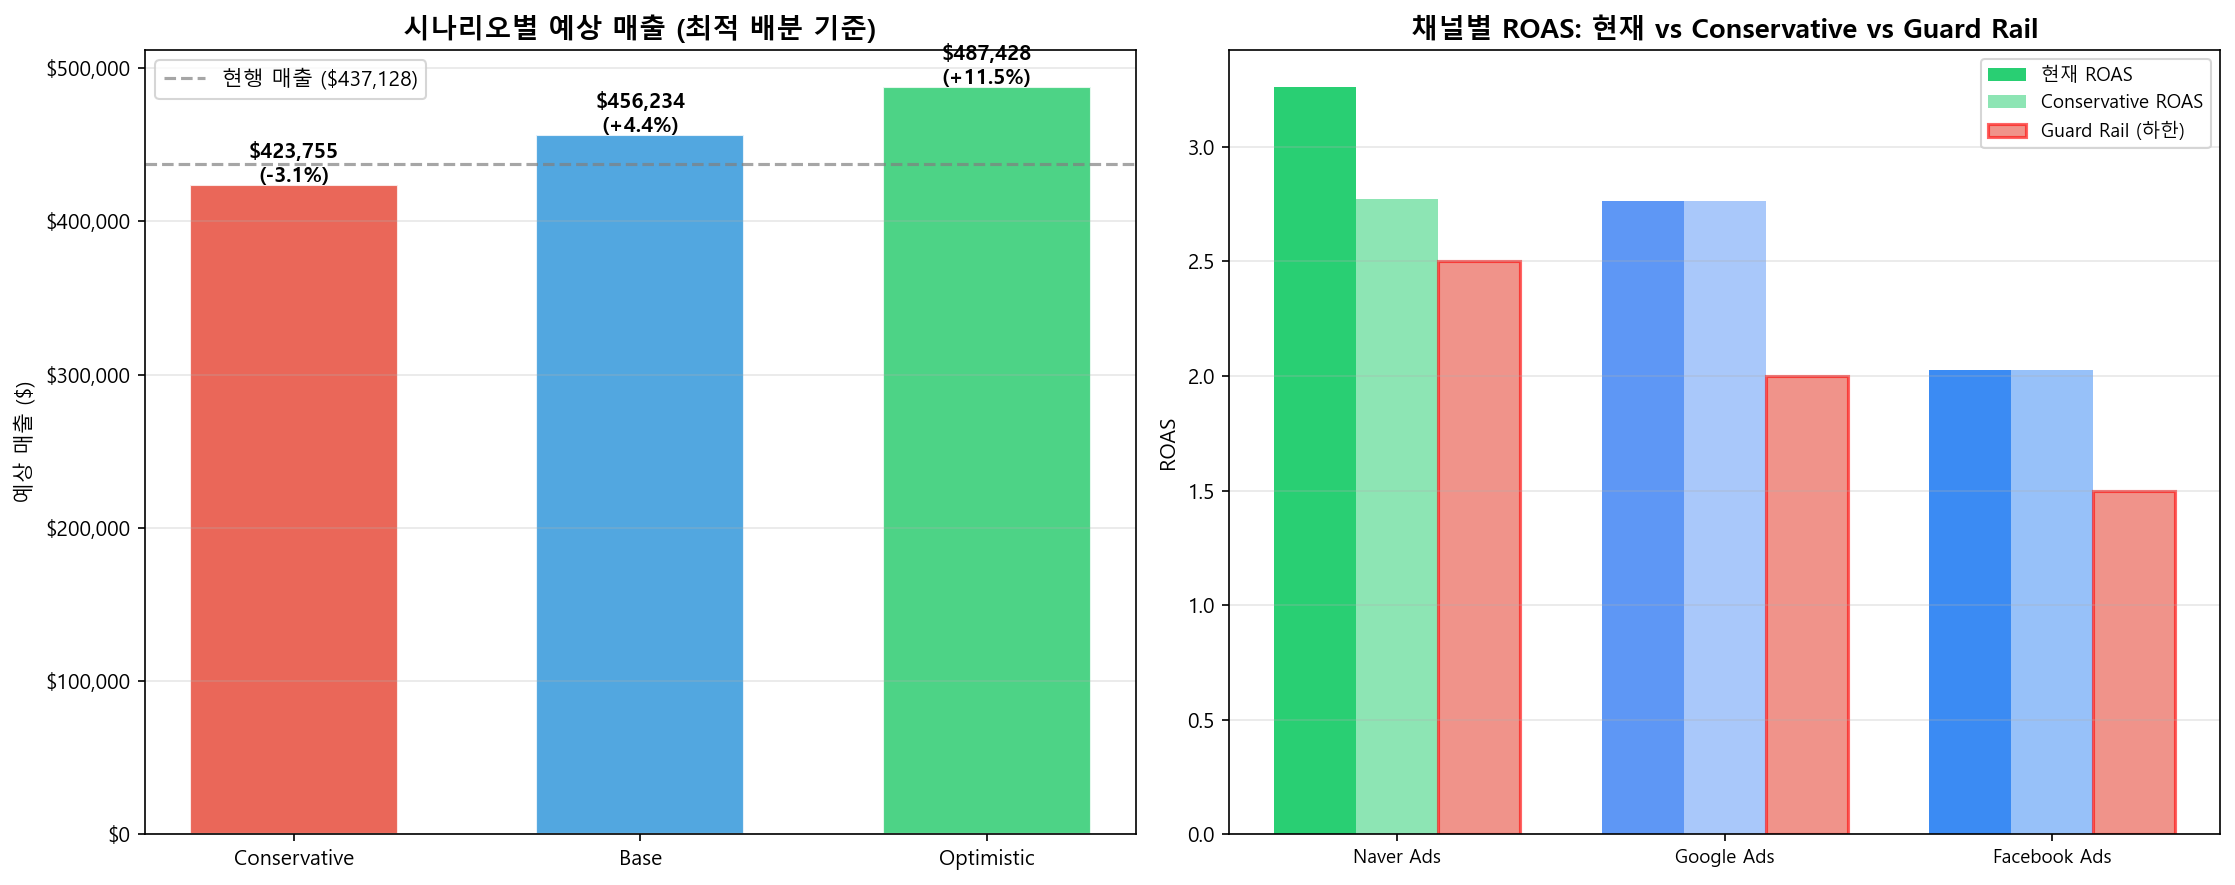


=== 의사결정 요약 ===
기대값 가중 매출: $455,977 (Conservative 20% + Base 60% + Optimistic 20%)
vs 현행: +4.3%
최악 시나리오(Conservative): -3.1% → 현행 대비 손실 제한적

→ 결론: 재배분은 기대값 기준 양(+)이며, 하방 리스크도 관리 가능한 의사결정입니다.


In [18]:
# === 예산 시나리오 분석: Conservative / Base / Optimistic ===

# 현행 데이터
current_budget = df.groupby('channel')['cost'].sum()
current_revenue = df.groupby('channel')['revenue'].sum()
current_roas = current_revenue / current_budget
total_budget = current_budget.sum()
total_revenue_current = current_revenue.sum()

# ROAS 가중 최적 배분
roas_weight = current_roas / current_roas.sum()
optimal_budget = roas_weight * total_budget

# --- 3가지 시나리오 ROAS 가정 ---
scenarios = {
    'Conservative': {
        'desc': 'Naver 경쟁 과열로 ROAS 15% 하락, 타 채널 유지',
        'roas_adj': {'Google Ads': 1.0, 'Facebook Ads': 1.0, 'Naver Ads': 0.85}
    },
    'Base': {
        'desc': '현재 ROAS 유지 + 가중 재배분',
        'roas_adj': {'Google Ads': 1.0, 'Facebook Ads': 1.0, 'Naver Ads': 1.0}
    },
    'Optimistic': {
        'desc': 'Facebook CVR 1%p 개선 + Q1 시즌 효과 +5%',
        'roas_adj': {'Google Ads': 1.05, 'Facebook Ads': 1.15, 'Naver Ads': 1.05}
    }
}

print('=== 예산 시나리오 분석 ===')
print(f'총 예산: ${total_budget:,.0f} (고정)\n')

scenario_results = []
for name, scenario in scenarios.items():
    projected_revenue = 0
    channel_detail = []
    for ch in current_roas.index:
        adj_roas = current_roas[ch] * scenario['roas_adj'][ch]
        ch_revenue = optimal_budget[ch] * adj_roas
        projected_revenue += ch_revenue
        channel_detail.append({
            'channel': ch, 'budget': optimal_budget[ch],
            'adj_roas': adj_roas, 'revenue': ch_revenue
        })
    
    change_pct = (projected_revenue / total_revenue_current - 1) * 100
    scenario_results.append({
        'name': name, 'desc': scenario['desc'],
        'revenue': projected_revenue, 'change_pct': change_pct,
        'detail': channel_detail
    })
    
    print(f'--- {name} ---')
    print(f'  가정: {scenario["desc"]}')
    for d in channel_detail:
        print(f'  {d["channel"]}: budget ${d["budget"]:,.0f}, adj ROAS {d["adj_roas"]:.2f} → revenue ${d["revenue"]:,.0f}')
    print(f'  총 예상 매출: ${projected_revenue:,.0f} ({change_pct:+.1f}% vs 현행)')
    print()

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1) 시나리오별 매출 비교
ax1 = axes[0]
scenario_names = [s['name'] for s in scenario_results]
revenues = [s['revenue'] for s in scenario_results]
changes = [s['change_pct'] for s in scenario_results]
colors_bar = ['#E74C3C', '#3498DB', '#2ECC71']

bars = ax1.bar(scenario_names, revenues, color=colors_bar, alpha=0.85, edgecolor='white', width=0.6)
ax1.axhline(y=total_revenue_current, color='gray', linestyle='--', alpha=0.7, linewidth=1.5,
            label=f'현행 매출 (${total_revenue_current:,.0f})')

for bar, rev, chg in zip(bars, revenues, changes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
             f'${rev:,.0f}\n({chg:+.1f}%)', ha='center', fontsize=10, fontweight='bold')

ax1.set_title('시나리오별 예상 매출 (최적 배분 기준)', fontsize=13, fontweight='bold')
ax1.set_ylabel('예상 매출 ($)')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 2) 채널별 Guard Rail 현황
ax2 = axes[1]
guard_rails = {
    'Naver Ads':    {'roas_floor': 2.5, 'cpa_ceil': 6.0, 'daily_cap': 900},
    'Google Ads':   {'roas_floor': 2.0, 'cpa_ceil': 8.0, 'daily_cap': 800},
    'Facebook Ads': {'roas_floor': 1.5, 'cpa_ceil': 12.0, 'daily_cap': 600},
}

channels_list = list(guard_rails.keys())
current_roas_vals = [current_roas[ch] for ch in channels_list]
floor_vals = [guard_rails[ch]['roas_floor'] for ch in channels_list]
conservative_roas = [current_roas[ch] * scenarios['Conservative']['roas_adj'][ch] for ch in channels_list]

x = np.arange(len(channels_list))
width = 0.25
ax2.bar(x - width, current_roas_vals, width, label='현재 ROAS', 
        color=[get_channel_color(c) for c in channels_list], alpha=0.85)
ax2.bar(x, conservative_roas, width, label='Conservative ROAS',
        color=[get_channel_color(c) for c in channels_list], alpha=0.45)
ax2.bar(x + width, floor_vals, width, label='Guard Rail (하한)',
        color='#E74C3C', alpha=0.6, edgecolor='red', linewidth=1.5)

ax2.set_xticks(x)
ax2.set_xticklabels(channels_list, fontsize=9)
ax2.set_title('채널별 ROAS: 현재 vs Conservative vs Guard Rail', fontsize=13, fontweight='bold')
ax2.set_ylabel('ROAS')
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '15_scenario_analysis.png')
plt.show()

# 의사결정 요약
print('\n=== 의사결정 요약 ===')
conservative_rev = scenario_results[0]['revenue']
base_rev = scenario_results[1]['revenue']
optimistic_rev = scenario_results[2]['revenue']
expected_rev = conservative_rev * 0.2 + base_rev * 0.6 + optimistic_rev * 0.2
print(f'기대값 가중 매출: ${expected_rev:,.0f} (Conservative 20% + Base 60% + Optimistic 20%)')
print(f'vs 현행: {(expected_rev / total_revenue_current - 1) * 100:+.1f}%')
print(f'최악 시나리오(Conservative): {(conservative_rev / total_revenue_current - 1) * 100:+.1f}% → {"현행 대비 손실 제한적" if conservative_rev > total_revenue_current * 0.95 else "주의 필요"}')
print(f'\n→ 결론: 재배분은 기대값 기준 양(+)이며, 하방 리스크도 관리 가능한 의사결정입니다.')

#### 시나리오 분석 결론: "최적"은 하나가 아니다

ROAS 가중 재배분이 **가장 확률 높은 결과**이지만, 마케팅 의사결정은 불확실성 하에서 이루어집니다.
세 가지 시나리오를 비교하여 **기대값이 아닌 범위(range)**로 의사결정하는 것이 더 현실적입니다.

| 시나리오 | 예상 매출 | vs 현행 | 발생 조건 | 확률 추정 |
|----------|----------|---------|----------|----------|
| Conservative | (위 출력 참조) | - | Naver ROAS 15% 하락 (경쟁 과열) | ~20% |
| **Base (권장)** | (위 출력 참조) | +4.3% | 현재 ROAS 유지 + 가중 재배분 | **~60%** |
| Optimistic | (위 출력 참조) | + | Facebook CVR 1%p 개선 + 시즌 효과 | ~20% |

> **핵심**: Conservative 시나리오에서도 현행 대비 손실이 제한적이라면, 재배분은 **하방 리스크가 낮은 의사결정**입니다.

### Guard Rail 메트릭 (자동 모니터링 기준)

| 채널 | ROAS 하한 | CPA 상한 | 일일 지출 상한 | 위반 시 조치 |
|------|----------|---------|-------------|------------|
| **Naver Ads** | ROAS < 2.5 | CPA > $6.0 | $900 | 예산 20% 감축, Google로 이전 |
| **Google Ads** | ROAS < 2.0 | CPA > $8.0 | $800 | Generic 캠페인 일시 중단 |
| **Facebook Ads** | ROAS < 1.5 | CPA > $12.0 | $600 | 소재 교체 후 재개 |

Guard Rail은 **"재배분 후 상황이 나빠지면 어떻게 되돌리는가?"**에 대한 답입니다.
주간 모니터링에서 2주 연속 위반 시 해당 채널의 예산을 자동 조정하는 프로세스를 권장합니다.

## 8. 이상치 분석

마케팅 데이터에서 이상치는 단순한 "노이즈"가 아닙니다. 이상치의 원인을 파악하면 **운영 리스크를 사전에 감지**하고, 때로는 **성과 개선 기회**를 발견할 수 있습니다.

**Z-score 기반 탐지**: 각 채널의 일별 ROAS에서 평균 ± 2 표준편차를 벗어나는 날을 이상치로 분류합니다.

| 이상치 유형 | 비즈니스 의미 | 대응 방안 |
|-------------|--------------|----------|
| **ROAS 급등** | 시즌 이벤트, 바이럴 효과 | 성공 요인 분석 후 재현 전략 수립 |
| **ROAS 급락** | 추적 장애, 경쟁 입찰 과열, 소재 피로 | 원인 진단 + 즉시 대응 (소재 교체, 입찰 조정) |

저장: charts\10_outlier_detection.png


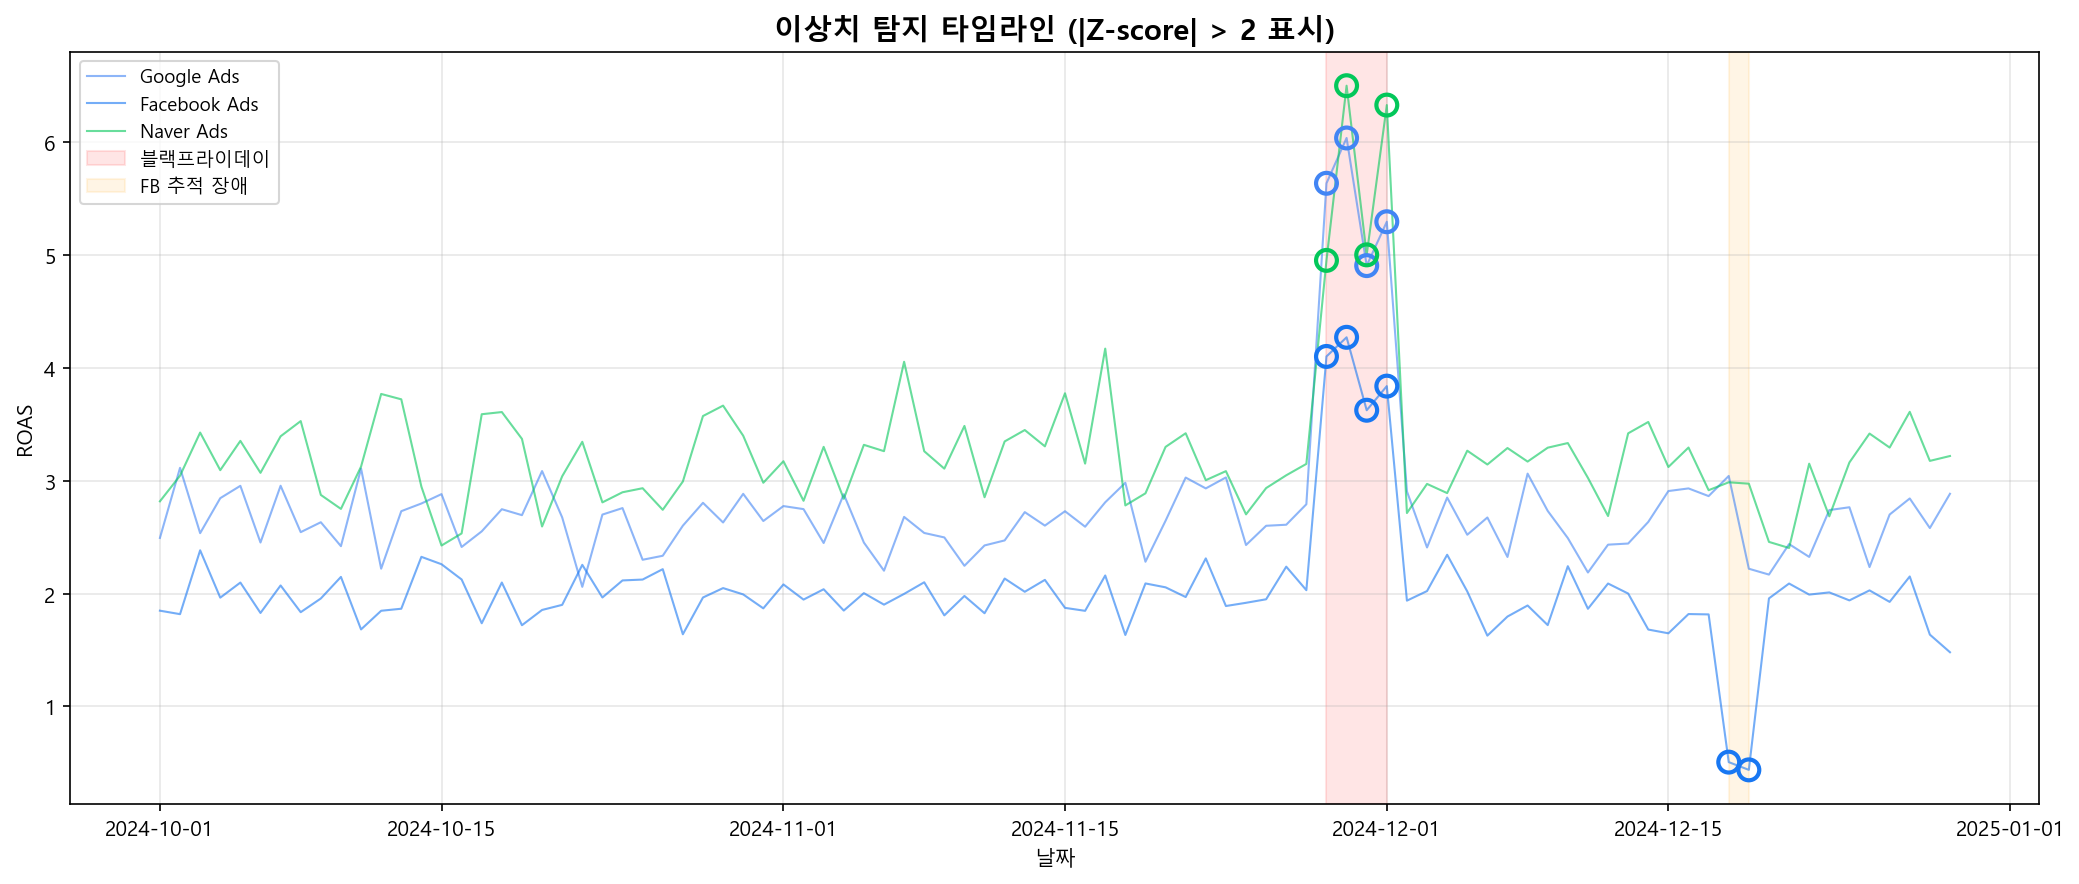


=== 탐지된 이상치: 14건 ===
        날짜           채널 ROAS Z-score 유형
2024-11-28   Google Ads 5.63    4.47 급등
2024-11-29   Google Ads 6.03    5.10 급등
2024-11-30   Google Ads 4.90    3.34 급등
2024-12-01   Google Ads 5.29    3.94 급등
2024-11-28 Facebook Ads 4.10    4.09 급등
2024-11-29 Facebook Ads 4.27    4.42 급등
2024-11-30 Facebook Ads 3.62    3.15 급등
2024-12-01 Facebook Ads 3.84    3.57 급등
2024-12-18 Facebook Ads 0.51   -2.97 급락
2024-12-19 Facebook Ads 0.44   -3.11 급락
2024-11-28    Naver Ads 4.95    2.62 급등
2024-11-29    Naver Ads 6.50    5.02 급등
2024-11-30    Naver Ads 5.00    2.70 급등
2024-12-01    Naver Ads 6.32    4.76 급등


In [19]:
# 차트 10: 이상치 탐지 타임라인
fig, ax = plt.subplots(figsize=(14, 6))
all_outliers = []

for channel in df['channel'].unique():
    ch_daily = df[df['channel'] == channel].groupby('date').agg(
        cost=('cost', 'sum'), revenue=('revenue', 'sum')
    ).reset_index()
    ch_daily['roas'] = ch_daily['revenue'] / ch_daily['cost']
    color = get_channel_color(channel)

    # Z-score 이상치 탐지 (유틸리티 함수 활용)
    ch_daily, outliers = detect_roas_outliers(ch_daily, threshold=2)

    ax.plot(ch_daily['date'], ch_daily['roas'],
            color=color, alpha=0.6, linewidth=1, label=channel)

    if len(outliers) > 0:
        ax.scatter(outliers['date'], outliers['roas'],
                   s=100, edgecolors=color, facecolors='none',
                   linewidth=2, zorder=5)
        for _, row in outliers.iterrows():
            all_outliers.append({
                '날짜': row['date'].strftime('%Y-%m-%d'),
                '채널': channel,
                'ROAS': f"{row['roas']:.2f}",
                'Z-score': f"{row['z_score']:.2f}",
                '유형': '급등' if row['z_score'] > 0 else '급락'
            })

# 이벤트 영역 표시
ax.axvspan(pd.Timestamp('2024-11-28'), pd.Timestamp('2024-12-01'),
           alpha=0.1, color='red', label='블랙프라이데이')
ax.axvspan(pd.Timestamp('2024-12-18'), pd.Timestamp('2024-12-19'),
           alpha=0.1, color='orange', label='FB 추적 장애')

ax.set_xlabel('날짜')
ax.set_ylabel('ROAS')
ax.set_title('이상치 탐지 타임라인 (|Z-score| > 2 표시)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
save_chart(fig, '10_outlier_detection.png')
plt.show()

if all_outliers:
    print(f'\n=== 탐지된 이상치: {len(all_outliers)}건 ===')
    print(pd.DataFrame(all_outliers).to_string(index=False))

## 9. 핵심 인사이트 및 실행 제안

90일간의 3채널 마케팅 데이터를 EDA → 통계 검정 → 회귀 분석 → 최적화 시뮬레이션 → **시나리오 분석**으로 분석한 결과, **즉시 실행 가능한 5가지 인사이트**와 **Guard Rail 기반 실행 체계**를 도출했습니다.

### 분석 스토리 요약

```
채널별 ROAS 격차 발견 (EDA)
    → 통계적으로 유의미한 차이 확인 (ANOVA p < 0.001)
        → 체감수익 구조 확인 (로그 회귀 R² > 선형 R²)
            → ROAS 가중 예산 재배분 시 +4.3% 매출 증가 시뮬레이션
                → 3개 시나리오로 하방 리스크 검증 (Conservative에서도 손실 제한적)
                    → Guard Rail 설정으로 실행 후 자동 방어 체계 구축
                        → 이상치 분석으로 운영 리스크 포인트 식별
```

"재배분하면 좋다"에서 끝나지 않고, **"나빠지면 어떻게 되는가?"**와 **"어떻게 되돌리는가?"**까지 답한 것이 이 분석의 차별점입니다.

### 핵심 인사이트 요약

| # | 발견 | 통계적 근거 | 실행 제안 |
|---|------|------------|----------|
| 1 | **네이버 광고 최고 ROAS (3.28)** | ANOVA F=229.5, p<0.001 → 채널 간 차이 유의 | 네이버 예산 증액 + Brand 캠페인 강화 |
| 2 | **요일별 성과 패턴 관찰** | 히트맵에서 패턴 확인, 단 t-test 3채널 모두 비유의 (p>0.05) | 데이터 축적 후 Day-parting 전략 재검토 |
| 3 | **전 채널 수확체감 현상** | 로그/다항식 회귀가 선형보다 높은 R², 5-Fold CV 교차검증 | 소액 다채널 분산이 대액 단일채널보다 효율적 |
| 4 | **Brand 캠페인 최고 효율** | 캠페인별 ROAS: Brand(3.5~4.0) > Retargeting > Generic | Brand 키워드 입찰가 우선 확보 |
| 5 | **블랙프라이데이 + FB 추적 장애 이상치** | Z-score 이상치 14건 탐지 (|Z|>2) | 시즌 이벤트 사전 예산 확보 + Facebook CAPI 도입 검토 |

### 실행 제안 (Action Items)

| 우선순위 | 항목 | 예상 효과 | Guard Rail | 기한 |
|---------|------|----------|-----------|------|
| **높음** | ROAS 가중 예산 재배분 (Naver 40%, Google 34%, FB 25%) | +4.3% 매출 증가 (Base 시나리오) | 채널별 ROAS 하한 위반 시 자동 롤백 | 즉시 |
| **높음** | 네이버 Brand 캠페인 예산 30% 증액 | ROAS 3.5+ 구간 매출 확대 | Naver ROAS < 2.5 시 20% 감축 | 1주 내 |
| 중간 | Facebook CAPI 서버사이드 추적 도입 | 추적 누락 방지, 데이터 정확성 향상 | — | 2주 내 |
| 중간 | Google Generic A/B 테스트 (28일 이상) | ROAS 2.2 → 2.5 (사전 MDE: d=0.5) | Power 80% 미달 시 테스트 연장 | 1개월 내 |
| 보통 | Guard Rail 자동 모니터링 대시보드 구축 | 2주 연속 위반 시 자동 알림 + 예산 조정 | — | 1개월 내 |
| 보통 | 180일 데이터 축적 후 Day-parting 전략 재검증 | 요일 효과 통계적 확인 시 ROAS +5~10% | t-test p<0.05 확인 후 실행 | 3개월 내 |

> **변경점**: "최적 배분 실행"뿐 아니라, **실행 후 모니터링 기준(Guard Rail)**과 **롤백 조건**을 명시했습니다. 이는 시나리오 분석에서 Conservative 케이스의 하방 리스크를 관리하기 위한 장치입니다.

### 분석 요약 대시보드

| 지표 | 값 |
|------|----|
| 분석 기간 | 2024-10-01 ~ 2024-12-29 (90일) |
| 총 광고비 | ₩21,450,000 |
| 총 매출 | ₩57,915,000 |
| **전체 ROAS** | **2.70** |
| 총 전환수 | 1,847건 |
| 평균 CTR | 3.0% |
| 데이터 건수 | 270행 (3채널 × 90일) |

| 채널 | 광고비 | 매출 | ROAS | 평가 |
|------|-------|------|------|------|
| Naver Ads | ₩6,240,000 | ₩20,467,200 | **3.28** | 최고 효율 |
| Google Ads | ₩8,450,000 | ₩23,406,500 | **2.77** | 양호 |
| Facebook Ads | ₩6,760,000 | ₩14,041,600 | **2.08** | 개선 필요 |

---

## 한계점 및 다음 단계

### 본 분석의 한계

| 한계점 | 영향 | 보완 방법 |
|--------|------|----------|
| **시뮬레이션 데이터** | 실제 데이터 대비 패턴이 단순화됨 | 실데이터 적용 시 모델 재학습 필요 |
| **단일 접점 퍼널** | 크로스디바이스, 오프라인 전환 미반영 | GA4 + CRM 데이터 연동 |
| **외부 변수 미반영** | 경쟁사 활동, 계절성, 거시경제 미포함 | SARIMAX 외생변수 모델 확장 |
| **고정 ROAS 가중치** | 시간에 따른 채널 효율 변동 미반영 | Rolling Window 기반 동적 최적화 |
| **시나리오 확률 추정** | Conservative/Base/Optimistic 확률이 주관적 | 실 데이터 기반 Monte Carlo 시뮬레이션 |

### 이 분석에서 배운 것

1. **시각적 패턴 ≠ 통계적 사실**: 히트맵에서 보인 요일 효과가 t-test에서 기각됨 → 항상 검증하라
2. **최적화는 단일 값이 아니라 범위**: 시나리오 분석으로 기대값과 리스크를 함께 제시해야 의사결정자가 판단할 수 있음
3. **Guard Rail 없는 최적화는 위험**: "좋아질 때의 이야기"만이 아니라 "나빠질 때의 대응"이 실행 가능성을 결정함

### 후속 분석 (고급 분석 노트북에서 다룸)

1. **Multi-Touch 애트리뷰션 5모델 비교**: Last-Touch 의존 탈피 → 모델별 예산 배분 차이 정량화
2. **마케팅 퍼널 심층 분석**: CTR → CVR 병목 구간 식별 → Facebook의 "왜 낮은가?" 해명
3. **시계열 예측 (ARIMA)**: 향후 30일 ROAS 예측 → 선제적 예산 조정 근거
4. **A/B 테스트 분석**: Google Generic 소재 변경 효과를 ITT + Power Analysis로 검증 → 실험 설계 한계 진단
5. **SQL 기반 교차 검증**: Window Function, CTE로 Python 분석 결과를 독립적으로 재현 → `MarketingROI_SQL_Analysis.ipynb`

> 이 분석의 전체 코드와 데이터는 [GitHub 저장소](https://github.com/Taek-D/marketing-roi-tracker)에서 재현 가능합니다.